In [1]:
# Compile all the code for the paper 'Decreased UHI under warmer conditions'
# only for years 2005-2016
# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import time
import cartopy.io.shapereader as shpreader
matplotlib.rcParams.update({'font.size': 18})

In [2]:
import cartopy
print(np.__version__, pd.__version__, ulmo.__version__, scipy.__version__,
      matplotlib.__version__, cartopy.__version__)
import sys
print(sys.version)

('1.10.4', u'0.18.1', '0.8.3dev', '0.17.1', '1.5.1', '0.13.1')
2.7.11 |Anaconda custom (x86_64)| (default, Dec  6 2015, 18:57:58) 
[GCC 4.2.1 (Apple Inc. build 5577)]


In [2]:
results_filename = 'US_results_2005pairs.csv'
results_filepath = 'plots/version5/2005pairs/'

In [3]:
#!mkdir plots/version5/2005pairs
#mkdir plots/version5/30yrtrend

In [591]:
ind.sum()

43

In [592]:
# functions
def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')
    
def color_scatter_years(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cmap = plt.cm.get_cmap('Greys_r', 7)
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = cmap)# cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[2005,1995, 2005, 2015], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['2005','1995', '2005', '2015'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .7), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p
def color_scatter(x,y,title, xlabel, ylabel): 
    fig, ax = plt.subplots()
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    cax = ax.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    #plt.scatter(x[ind],y[ind], c = x[ind].index, cmap = plt.cm.bone)
    cbar = fig.colorbar(cax, ticks=[6000,16800], orientation='horizontal')
    #plt.colorbar()
    cbar.ax.set_xticklabels(['2005', '2016'])  # horizontal colorbar
    ax.plot(x, m*x+b, color = 'black')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    ax.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m,r,p

# plotting 
# define functions used for plotting 
def lin_trend_plot(start_x, y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
    x = np.arange(0,y.shape[0])
    m, b, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
    plt.scatter(x+start_x,y)
    plt.plot(x+start_x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r_value), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r_value, p, std_err

def hw_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    if type(ind) != 'numpy.ndarray': 
        N= ind.sum()
    else: 
        N = ind.shape()
        
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(N), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

# statistics
def pearsonr_autocorrelated(x, y):
    """
    Calculates a Pearson correlation coefficient and the p-value for testing
    non-correlation.
    The Pearson correlation coefficient measures the linear relationship
    between two datasets. Strictly speaking, Pearson's correlation requires
    that each dataset be normally distributed. Like other correlation
    coefficients, this one varies between -1 and +1 with 0 implying no
    correlation. Correlations of -1 or +1 imply an exact linear
    relationship. Positive correlations imply that as x increases, so does
    y. Negative correlations imply that as x increases, y decreases.
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Pearson correlation at least as extreme
    as the one computed from these datasets. The p-values are not entirely
    reliable but are probably reasonable for datasets larger than 500 or so.
    Parameters
    ----------
    x : (N,) array_like
        Input
    y : (N,) array_like
        Input
    Returns
    -------
    (Pearson's correlation coefficient,
     2-tailed p-value)
    References
    ----------
    http://www.statsoft.com/textbook/glosp.html#Pearson%20Correlation
    """
    # x and y should have same length.
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    r = np.corrcoef(y[1:],y[0:-1])[0,1] #y.autocorr(1)
    n_prime = n*(1-r)/(1+r)
    mx = x.mean()
    my = y.mean()
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym)
    r_den = np.sqrt(ss(xm) * ss(ym))
    r = r_num / r_den

    # Presumably, if abs(r) > 1, then it is only some small artifact of floating
    # point arithmetic.
    r = max(min(r, 1.0), -1.0)
    df = n_prime-2
    if abs(r) == 1.0:
        prob = 0.0
    else:
        t_squared = r*r * (df / ((1.0 - r) * (1.0 + r)))
        prob = betai(0.5*df, 0.5, df / (df + t_squared))
    return r, prob

def ss(a, axis=0):
    """
    Squares each element of the input array, and returns the sum(s) of that.
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int or None, optional
        The axis along which to calculate. If None, use whole array.
        Default is 0, i.e. along the first axis.
    Returns
    -------
    ss : ndarray
        The sum along the given axis for (a**2).
    See also
    --------
    square_of_sums : The square(s) of the sum(s) (the opposite of `ss`).
    Examples
    --------
    >>> from scipy import stats
    >>> a = np.array([1., 2., 5.])
    >>> stats.ss(a)
    30.0
    And calculating along an axis:
    >>> b = np.array([[1., 2., 5.], [2., 5., 6.]])
    >>> stats.ss(b, axis=1)
    array([ 30., 65.])
    """
    a, axis = _chk_asarray(a, axis)
    return np.sum(a*a, axis)

def _chk_asarray(a, axis):
    if axis is None:
        a = np.ravel(a)
        outaxis = 0
    else:
        a = np.asarray(a)
        outaxis = axis
    return a, outaxis

def betai(a, b, x):
    """
    Returns the incomplete beta function.
    I_x(a,b) = 1/B(a,b)*(Integral(0,x) of t^(a-1)(1-t)^(b-1) dt)
    where a,b>0 and B(a,b) = G(a)*G(b)/(G(a+b)) where G(a) is the gamma
    function of a.
    The standard broadcasting rules apply to a, b, and x.
    Parameters
    ----------
    a : array_like or float > 0
    b : array_like or float > 0
    x : array_like or float
        x will be clipped to be no greater than 1.0 .
    Returns
    -------
    betai : ndarray
        Incomplete beta function.
    """
    x = np.asarray(x)
    x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
    return scipy.special.betainc(a, b, x)

def map_hist_plot(data, paired_df, title = 'Response of $\Delta T$ to Temperature Change', data_label = 'm$_{JJA}$ ($^\circ$C$ / ^\circ $C)', label_city = False, c_insignificant = np.array([]), ) : 
    # plots a map and histogram of data, a pandas dataframe with cities in the index 
    # paired_df 
    # results_df[results_df['P-value']>0.05]
    fig = plt.figure(figsize=[15,7])
    ax = plt.axes([0, 0, 1, 1],
                       projection=ccrs.LambertConformal())
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    ax.set_title(title)
    # download default shapefils from natura_earth using cartopy's shapereader
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # to get the effect of having just the states without a map "background"
    # turn off the outline and background patches
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    # Plot background state map
    for state in shpreader.Reader(states_shp).geometries():
        # pick a default color for the land with a black outline,
        # this will change if the storm intersects with our track
        facecolor = 'None'#[0.9375, 0.9375, 0.859375]
        edgecolor = 'black'
        ax.add_geometries([state], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

    # define data
    data = data[~np.isnan(data)]
    # Set up colors for plotting
    cmap = matplotlib.cm.coolwarm
    c = data
    bounds = np.linspace(-1,1,11)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    marker_size = 150

    # plot data
    plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                            c = c.values, s = marker_size, alpha = 1, 
                            transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                     cmap = cmap,
                     norm = norm, zorder = 1, )
    ax.set_title('a) ')
    # plot significance
    #c_insignificant = results_df[results_df['P-value']>0.05]
    if c_insignificant.shape[0] > 0 : 
        ax.scatter(paired_df.set_index('City').loc[c_insignificant.index]['Urban Lon'], paired_df.set_index('City').loc[c_insignificant.index]['Urban Lat'], 
        #paired_df['Urban Lon'].iloc[insig_inds], paired_df['Urban Lat'].iloc[insig_inds], 
            c = 'none', s = marker_size, transform=ccrs.Geodetic(), edgecolors='white',linewidth = 4)

    if label_city == True: 
        for city, lon, lat in zip(c.index, paired_df.set_index('City').loc[c.index]['Urban Lon'].values, paired_df.set_index('City').loc[c.index]['Urban Lat'].values): 
            if city != 'Honolulu': 
                ax.text(lon+.5,lat, city,
                        #xy = (paired_df.set_index('City').loc[c.index]['Rural Lon'].values, paired_df.set_index('City').loc[c.index]['Rural Lat'].values), 
                       transform = ccrs.Geodetic(), 
                        horizontalalignment='left',)


#     cb = plt.colorbar(plotHandle, label = data_label, #'Slope m$_{JJA}$ ($^\circ$C$ / ^\circ $C)',
#                       orientation='horizontal', shrink = .5)
#     cb.outline.remove()

    ##### Histogram 
    sub_ax = plt.axes([0.05, 0.0, 0.22, 0.25])
    #plot data
    n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
    # annotate and label 
    sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(1.0, .3), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(1.0, .15), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(1.0, 0), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    sub_ax.set_xlabel(data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
    sub_ax.set_ylabel('Count')
    sub_ax.set_title('b)')
    if data.max() < 0.1 : 
        sub_ax.set_xticks(sub_ax.get_xticks()[::2])

    # set histogram colors 
    m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
    m._A = []

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
        plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
    #plt.colorbar(m)
    prettify_plot()
    return fig, ax, sub_ax

In [9]:
#pairs = pd.read_csv('USpairs_stationlengths_stationavailability75_noairport.csv')
# pairs = pd.read_csv('NovUSpairs_stationlengths_stationavailability75.csv')
# paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
# paired_df = paired_df.drop(2)
# drop_cities = ['Mesa','Long Beach','St. Petersburg', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
# paired_df = paired_df.set_index(paired_df['City']).drop(drop_cities)

In [5]:
paired_df = pd.read_csv('USpairs2005-2015.csv').set_index('City', drop = False)

In [29]:
# Calculate the relationship between summertime  UHI and t_min, save it out for every city
# pre-allocate
#summertime
slopes           = np.ones(paired_df.shape[0])*np.nan
residuals        = np.ones(paired_df.shape[0])*np.nan
correlations     = np.ones(paired_df.shape[0])*np.nan
urban_start_date = np.ones(paired_df.shape[0])*np.nan
urban_end_date   = np.ones(paired_df.shape[0])*np.nan
rural_start_date = np.ones(paired_df.shape[0])*np.nan
rural_end_date   = np.ones(paired_df.shape[0])*np.nan
n_events         = np.ones(paired_df.shape[0])*np.nan
mean_rural_temp  = np.ones(paired_df.shape[0])*np.nan
mean_UHI         = np.ones(paired_df.shape[0])*np.nan
p_value          = np.ones(paired_df.shape[0])*np.nan
intercepts       = np.ones(paired_df.shape[0])*np.nan
max_UHI_day      = np.ones(paired_df.shape[0])*np.nan
UHI_lin_trend = np.ones(paired_df.shape[0])*np.nan
UHI_lin_trend_pvalue = np.ones(paired_df.shape[0])*np.nan
urban_lin_trend = np.ones(paired_df.shape[0])*np.nan
urban_lin_trend_pvalue = np.ones(paired_df.shape[0])*np.nan
        
trend_results = np.ones([paired_df.shape[0], 10])*np.nan

#heatwave
hwslopes =np.ones(paired_df.shape[0])*np.nan
hwintercepts =np.ones(paired_df.shape[0])*np.nan
hwresiduals =np.ones(paired_df.shape[0])*np.nan
hwcorrelations =np.ones(paired_df.shape[0])*np.nan
hwp_value =np.ones(paired_df.shape[0])*np.nan
hwn_events =np.ones(paired_df.shape[0])*np.nan
hwmean_rural_temp =np.ones(paired_df.shape[0])*np.nan
hwmean_UHI =np.ones(paired_df.shape[0])*np.nan

#heatwave composite
composite_tmin = np.ones([paired_df.shape[0], 11])*np.nan
composite_UHImin = np.ones([paired_df.shape[0], 11])*np.nan

numhw = 150
finalhw = 50

In [295]:
#heatwave composite
composite_tmin = np.ones([paired_df.shape[0], 11])*np.nan
composite_UHImin = np.ones([paired_df.shape[0], 11])*np.nan

numhw = 150
finalhw = 50

In [296]:
# Summertime UHI and temperature
toc = time.time() #time
#for i in range(20,21):#
#for i in range(0, paired_df.shape[0]): 
#for i in range(20,21): # just do Baltimore 
for i in range(0, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['2005-06-01':].index, ruraldata['TMIN']['2005-06-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['2005-06-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['2005-06-01':].value/10.) 
        
#         rural_start_date[i] = rural_tmin[~np.isnan(rural_tmin)].index[0].year
#         rural_end_date[i]   = rural_tmin[~np.isnan(rural_tmin)].index[-1].year
#         urban_start_date[i] = urban_tmin[~np.isnan(urban_tmin)].index[0].year
#         urban_end_date[i]   = urban_tmin[~np.isnan(urban_tmin)].index[-1].year
        
        # extract summertime data 
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
        
        # clean data: eliminate min temperatures below 4 or above 35
        rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
        urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
        #calculate UHI
        UHI = urban_summer - rural_summer
        
        # Save out the mean temperature and UHI
#         mean_UHI[i] = UHI.mean()
#         max_UHI_day[i] = UHI.groupby(UHI.index.day_of_year).mean().argmax() # average yearly UHI cycle, and see which day has max UHI
#         mean_rural_temp[i] = rural_summer.mean()
        #select available data points
#         clim = UHI.groupby(UHI.index.day_of_year).mean()
#         anomaly = UHI.values - (clim[UHI.index.day_of_year].values)
# #         ind = ~np.isnan(anomaly)
#         try:
#             title = '%s 30 yr trend in '%city
#             fig = plt.figure(figsize=[10,4] )
#             plt.subplot(121)
#             slopeT, interceptT, r_valueT, pT, std_errT = lin_trend_plot(2005,rural_summer.groupby(rural_summer.index.year).mean(),'a) ' + title + '$T_r$', 'Years since 2005','Mean JJA $T_r$')
#             plt.subplot(122)
#             slope, intercept, r_value, p, std_err = lin_trend_plot(2005, UHI.groupby(UHI.index.year).mean(),'b) ' + title + '$\Delta T$', 'Years since 2005', 'Mean JJA $\Delta T$')
#             plt.savefig(results_filepath+ '30yrtrend/%s.png'%city)
#             plt.close()
            
#             slopeU, interceptU, r_valueU, pU, std_errU = lin_trend_plot(2005, urban_summer.groupby(urban_summer.index.year).mean(),'b) ' + title + '$\Delta T$', 'Years since 2005', 'Mean JJA $\Delta T$')
#             plt.close()
            
#         except ValueError:
#             slopeT, interceptT, r_valueT, pT, std_errT= np.ones(5)*np.nan
#             slope, intercept, r_value, p, std_err = np.ones(5)*np.nan

        # save out
#         trend_results[i, 0:5] = slopeT, interceptT, r_valueT, pT, std_errT
#         trend_results[i, 5:] = slope, intercept, r_value, p, std_err
#         UHI_lin_trend[i] = slope
#         UHI_lin_trend_pvalue[i] = p
#         urban_lin_trend[i] = slopeU
#         urban_lin_trend_pvalue[i] = pU
        
        ######
        ###### Calculate heatwaves
        ######        
        hottestmin = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] 
        minheatwaves = hottestmin[0:12]
        
        Ns = []
        m = 0 
        for n in range(1,11): 
            old = m
            try: 
                while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                    m = m+1
            except IndexError: 
                minheatwaves = hottestmin[0:20]
                try: 
                    while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                        m = m+1
                except IndexError: 
                    print('out of bounds')
            try: 
                if old ==m : 
                    Ns.append(minheatwaves.sort_index().index[m])
                else: 
                    Ns.append(minheatwaves.sort_index()[old:m].argmax())
            except: 
                'random error'
            m = m+1
        finalhw = hottestmin[Ns].sort_values(ascending=False)

        # plot composite heatwave events
#         heatwaves = finalhw
#         compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
#         compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
#         ii = 0
#         for dates in heatwaves.index: 
#             compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
#             compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
#             ii = ii+1
#         ### make sure that heatwaves aren't duplicates
#         Ns = []
#         m = 0 
#         for n in range(1,11): 
#             old = m
#             try: 
#                 while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
#                     m = m+1
#             except IndexError: 
#                 minheatwaves = hottestmin[0:20]
#                 try: 
#                     while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
#                         m = m+1
#                 except IndexError: 
#                     print('out of bounds')
#             try: 
#                 if old ==m : 
#                     Ns.append(minheatwaves.sort_index().index[m])
#                 else: 
#                     Ns.append(minheatwaves.sort_index()[old:m].argmax())
#             except: 
#                 'random error'
#             m = m+1
#         finalhw = hottestmin[Ns].sort_values(ascending=False)

        ######
        ###### Analyze summer and heatwave data
        ######
        x = rural_summer
        y = UHI
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        try: 
            #heatwaves
#             hw_x = rural_summer[hottestmin.index]#[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
#             hw_y = UHI[hottestmin.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
#             hw_ind = ~np.isnan(hw_y) & ~np.isnan(hw_x) # subset values that aren't NaNs

#             # plot summertime temp vs UHI
#             plt.figure()
#             m, r, p = hw_scatter(x[ind],y[ind],'%s JJA $T_r$ vs. $\Delta T$'%city, 'Rural Temp ($^\circ$C)', 'UHI ($\Delta ^\circ$C)')
#             plt.savefig(results_filepath+ 'JJAUHI%s%s.pdf'%(city.replace(" ", "")[0:5], 'min'))
#             plt.close()

#             # plot heatwave temp vs UHI
#             plt.figure()
#             m, r, p = hw_scatter(hw_x[hw_ind],hw_y[hw_ind],'%s Heatwave $T_r$ vs. $\Delta T$'%city, 'HW Rural Temp ($^\circ$C)', 'HW UHI ($\Delta ^\circ$C)')
#             plt.savefig(results_filepath+ 'hwUHI%s%s.pdf'%(city.replace(" ", "")[0:5], 'min'))
#             plt.close()
#             hwslopes[i] = m
#             hwcorrelations[i] = r
#             hwp_value[i] = p

#             # plot composite heatwave events
            heatwaves = finalhw
            compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
            compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
            ii = 0
            for dates in heatwaves.index[:]: 
                compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
                ii = ii+1

#             plt.figure(figsize=[12,4])
#             plt.subplot(1,2,1)
#             tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
#             plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
#             plt.title('Min %s Temp'%(city))
#             plt.ylabel('Temp. ($^\circ C$)')
#             plt.xlabel('Heatwave Day')

#             plt.subplot(1,2,2)    
#             uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
#             plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
#             plt.title('Min %s UHI'%(city))
#             plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
#             plt.xlabel('Heatwave Day')
#             plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
#             plt.savefig(results_filepath+'min'+'hwcomposite%s'%city.replace(" ", "")[0:5]+'.pdf',  bbox_inches='tight')        # save out 
#             plt.close()
            composite_tmin[i,:] = np.nanmean(compositeTemp, axis=0)
            composite_UHImin[i,:] = np.nanmean(compositeUHI, axis=0)
#             # save out data

#             # first, save out summertime 
#             slope, intercept, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
#             #V = np.polyfit(x[ind],y[ind],1, full = True)
#             C = pearsonr_autocorrelated(x[ind], y[ind])
#             slopes[i] = slope #V[0][0]
#             intercepts[i] = intercept
#             residuals[i] = std_err#V[1][0]
#             correlations[i] = r_value#C[0]#np.corrcoef(x[ind],y[ind])[0,1]
#             p_value[i] = C[1]
#             n_events[i] = ind.values.sum()
            
#             # second, heatwaves 
#             slope, intercept, r_value, p, std_err = scipy.stats.linregress(hw_x[hw_ind],hw_y[hw_ind])
#             C = pearsonr_autocorrelated(hw_x[hw_ind],hw_y[hw_ind])
#             hwslopes[i] = slope
#             hwintercepts[i] = intercept
#             hwresiduals[i] = std_err
#             hwcorrelations[i] = r_value
#             hwp_value[i] = C[1]# p
#             hwn_events[i] = hw_ind.values.sum()
#             hwmean_rural_temp[i] = hw_x.mean()
#             hwmean_UHI[i] = hw_y.mean()
            
        except TypeError : 
            print 'TypeError'
#     #save out
#     if np.mod(i,10) == 0 : 
#         # summmertime
#         results_df = pd.DataFrame()
#         results_df['City']  = paired_df['City']
#         results_df['Slope'] = slopes
#         results_df['Intercepts'] = intercepts
#         results_df['Residual'] = residuals
#         results_df['Correlation'] = correlations
#         results_df['P-value'] = p_value
#         results_df['Urban start date'] = urban_start_date
#         results_df['Urban end date'] = urban_end_date
#         results_df['Rural start date'] = rural_start_date
#         results_df['Rural end date'] = rural_end_date
#         results_df['Data points'] = n_events
#         results_df['Mean UHI'] = mean_UHI
#         results_df['Day of Max UHI'] = max_UHI_day
#         results_df['Mean JJA Rural Temp'] = mean_rural_temp
#         results_df['UHI linear trend'] = UHI_lin_trend
#         results_df['UHI linear trend p-value'] = UHI_lin_trend_pvalue
#         results_df['Urban linear trend'] = urban_lin_trend
#         results_df['Urban linear trend p-value'] = urban_lin_trend_pvalue        
        
#         # heatwaves
#         results_df['hw Slope'] = hwslopes
#         results_df['hw P-value'] = hwp_value
#         results_df['hw Residual'] = hwresiduals
#         results_df['hw Correlation'] = hwcorrelations
#         results_df['hw Data points'] = hwn_events          
#         results_df['hw Mean UHI'] = hwmean_UHI
#         results_df['hw Mean JJA Rural Temp'] = hwmean_rural_temp
#         # save out results
#         results_df.to_csv(results_filepath + results_filename)
#         # save out composite heatwave events
        pd.DataFrame(composite_tmin, index = paired_df.index).to_csv(results_filepath + 'composite_temp.csv')
        pd.DataFrame(composite_UHImin, index = paired_df.index).to_csv(results_filepath + 'composite_UHI.csv')
#         np.savetxt((results_filepath + 'composite_temp.csv'), composite_tmin, delimiter = ',')
#         np.savetxt((results_filepath + 'composite_UHI.csv'), composite_UHImin, delimiter = ',')
#         cols = ['Annual Temp Slope', 'Temp Intercept', 'Temp Correlation', 'Temp p-value', 'Temp Std. Err.', 
#                'Annual UHI Slope', 'UHI Intercept', 'UHI Correlation', 'UHI p-value', 'UHI Std. Err.']
#         pd.DataFrame(trend_results, columns = cols).to_csv(results_filepath+'30yrtrend/trend_results.csv')

# cols = ['Annual Temp Slope', 'Temp Intercept', 'Temp Correlation', 'Temp p-value', 'Temp Std. Err.', 
#        'Annual UHI Slope', 'UHI Intercept', 'UHI Correlation', 'UHI p-value', 'UHI Std. Err.']
# pd.DataFrame(trend_results, columns = cols).to_csv(results_filepath+'30yrtrend/trend_results.csv')
# #save out final data        
# results_df['City']  = paired_df['City']
# results_df['Slope'] = slopes
# results_df['Intercepts'] = intercepts
# results_df['Residual'] = residuals
# results_df['Correlation'] = correlations
# results_df['P-value'] = p_value
# results_df['Urban start date'] = urban_start_date
# results_df['Urban end date'] = urban_end_date
# results_df['Rural start date'] = rural_start_date
# results_df['Rural end date'] = rural_end_date
# results_df['Data points'] = n_events
# results_df['Mean UHI'] = mean_UHI
# results_df['Day of Max UHI'] = max_UHI_day
# results_df['Mean JJA Rural Temp'] = mean_rural_temp
# results_df['UHI linear trend'] = UHI_lin_trend
# results_df['UHI linear trend p-value'] = UHI_lin_trend_pvalue
# results_df['Urban linear trend'] = urban_lin_trend
# results_df['Urban linear trend p-value'] = urban_lin_trend_pvalue        

# # heatwaves
# results_df['hw Slope'] = hwslopes
# results_df['hw P-value'] = hwp_value
# results_df['hw Residual'] = hwresiduals
# results_df['hw Correlation'] = hwcorrelations
# results_df['hw Data points'] = hwn_events
# results_df['hw Mean UHI'] = hwmean_UHI
# results_df['hw Mean JJA Rural Temp'] = hwmean_rural_temp
# # save out results
# results_df.to_csv(results_filepath + results_filename)
# # save out composite heatwave events
# np.savetxt((results_filepath + 'composite_temp.csv'), composite_tmin, delimiter = ',')
# np.savetxt((results_filepath + 'composite_UHI.csv'), composite_UHImin, delimiter = ',')
                    
tic = time.time()
print('Elapsed time: ', tic-toc)

Mesa
Grand Prairie
out of bounds
Irvine
Fort Lauderdale
Long Beach
Hartford
out of bounds
out of bounds
Providence
Virginia Beach
Oakland
West Palm Beach
Louisville
Columbus
San Bernardino
St. Paul
Tucson
Fresno
out of bounds
Albuquerque
Ft. Worth
out of bounds
out of bounds
out of bounds
Austin
out of bounds
out of bounds
out of bounds
out of bounds
Indianapolis
Baltimore
San Jose
out of bounds
out of bounds
out of bounds
Sacramento
Las Vegas
Portland
Omaha
Raleigh
Cleveland
Cincinnati
Nashville
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
out of bounds
St. Louis
New Orleans
Dallas
out of bounds
Philadelphia
Detroit
San Francisco
Denver
Miami
Chicago
Los Angeles
Washington, D.C.
New York
('Elapsed time: ', 3656.8439519405365)


In [13]:
results_df = pd.read_csv(results_filepath + results_filename).set_index('City.1')
paired_df = paired_df[paired_df['Urban distance']< 0.2]

In [14]:
results_filepath

'plots/version5/2005pairs/'

In [136]:
# atlas = pd.read_csv('data/world_cities.csv').set_index('city')
# atlas = atlas[(atlas['country'] == 'United States of America') & (atlas['pop']>100000)]
# drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
# publication_results = pd.DataFrame()
# #publication_results['Population'] = atlas.loc[results_df.drop(drop_cities, axis = 0).index]['pop']
# publication_results['Population'] = atlas.loc[results_df.index]['pop']
# publication_results[['Mean JJA Rural Temp', 'Mean UHI', 'Slope', 'Correlation', 'P-value', 
#             'Data points', 'Day of Max UHI', 'UHI linear trend','UHI linear trend p-value',
#            'hw Mean UHI','hw Correlation', 'hw Slope', 'hw Data points' ]] = results_df[['Mean JJA Rural Temp', 'Mean UHI', 'Slope', 'Correlation', 'P-value', 
#             'Data points', 'Day of Max UHI', 'UHI linear trend','UHI linear trend p-value',
#            'hw Mean UHI','hw Correlation', 'hw Slope', 'hw Data points' ]]#.drop(drop_cities, axis = 0)
# publication_results.sort_values('Population', ascending = False).to_csv(results_filepath+'ScottEtAlresults.csv')

Baltimore
Miami


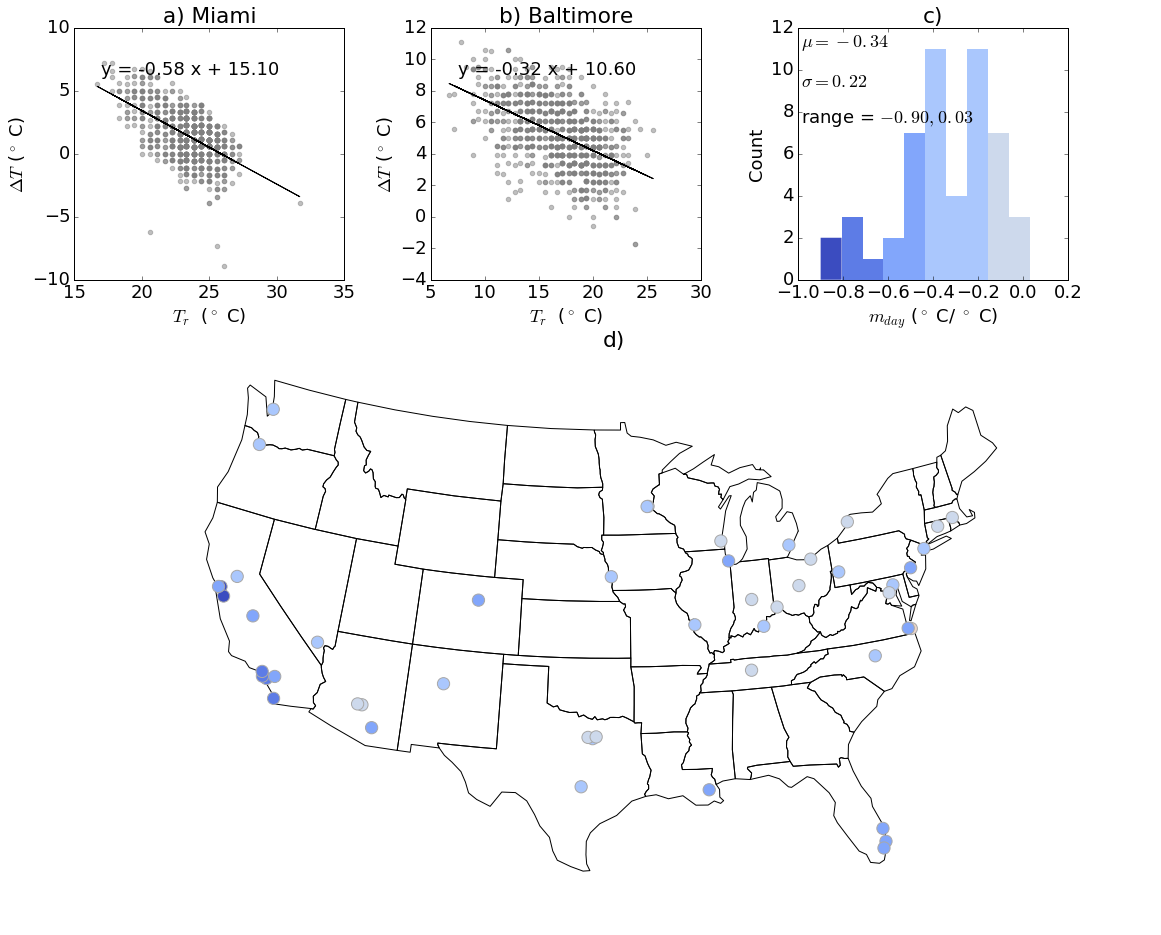

In [242]:
### Figure 1) 

def inset_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey', alpha = .5)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.1, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

fig = plt.figure(figsize=[15,10])
#ax = fig.add_subplot(224, projection=ccrs.LambertConformal())
ax = plt.axes([0, 0, 1, 1],
                    projection=ccrs.LambertConformal())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# Plot background state map
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor = 'None'#[0.9375, 0.9375, 0.859375]
    edgecolor = 'black'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

# define data
cities =paired_df[paired_df['Urban distance']< 0.2].index#
data = results_df['Slope'][cities]
#data = results_df['Slope']
data = data[~np.isnan(data)]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.title('d)')

######
dummy_ind = 0
#for i in [15, 19]: 
for city in ['Baltimore', 'Miami']:
    # = paired_df.loc[i]['City']
    #city = unicode(city, errors = 'ignore')
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    ######
    ###### Import data
    ######
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['2005-06-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['2005-06-01':].value/10.)         
    # extract summertime data 
    rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
    urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
    # clean data: eliminate min temperatures below 4 or above 35
    rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
    urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

    #calculate UHI
    UHI = urban_summer - rural_summer
    if dummy_ind ==0 : 
        #sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])
        sub_ax2 = plt.axes([0.33, 1.0, 0.25, 0.35])

        #sub_ax3 = plt.axes([0.9, 0.0, 0.25, 0.35])
        inset_scatter(rural_summer[UHI.index], UHI,'b) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 
    else: 
        sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])

        #sub_ax2 = plt.axes([0.9, 0.6, 0.25, 0.35])
        inset_scatter(rural_summer[UHI.index], UHI,'a) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 
    ##### Inset plot     
    dummy_ind = dummy_ind+1
    


sub_ax = plt.axes([0.67, 1.0, 0.25, 0.35])#plt.subplot2grid((3,3), (0,3))
n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
# annotate and label 
sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(0.01, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(0.01, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(0.01, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.set_xlabel('$m_{day}$ ($^\circ$ C/ $^\circ$ C)')#data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
sub_ax.set_ylabel('Count')
sub_ax.set_title('c)')

# set colors 
m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
m._A = []

bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
    plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
plt.savefig(results_filepath+ 'fullJJAslopes.pdf', bbox_inches='tight')

In [319]:
compositeTempDF = pd.read_csv(results_filepath+'composite_temp.csv').set_index('City')
compositeTempDF.columns = x
compositeTempDF.head()

-5     -4     -3     -2     -1      0      1          2  \
City                                                                          
Mesa             26.43  25.35  27.10  26.66  27.34  30.62  27.46  26.911111   
Grand Prairie    25.32  26.22  25.67  25.67  26.22  28.33  27.28  25.940000   
Irvine           18.06  18.68  18.90  20.96  24.24  27.38  25.32  21.280000   
Fort Lauderdale  23.83  24.15  23.65  24.01  24.89  26.29  25.22  24.600000   
Long Beach       16.85  17.59  19.55  20.16  22.34  25.24  24.68  22.120000   

                     3      4      5  
City                                  
Mesa             27.46  26.45  25.67  
Grand Prairie    25.60  25.46  24.27  
Irvine           18.67  17.27  16.29  
Fort Lauderdale  24.17  23.76  23.82  
Long Beach       20.28  18.95  17.68

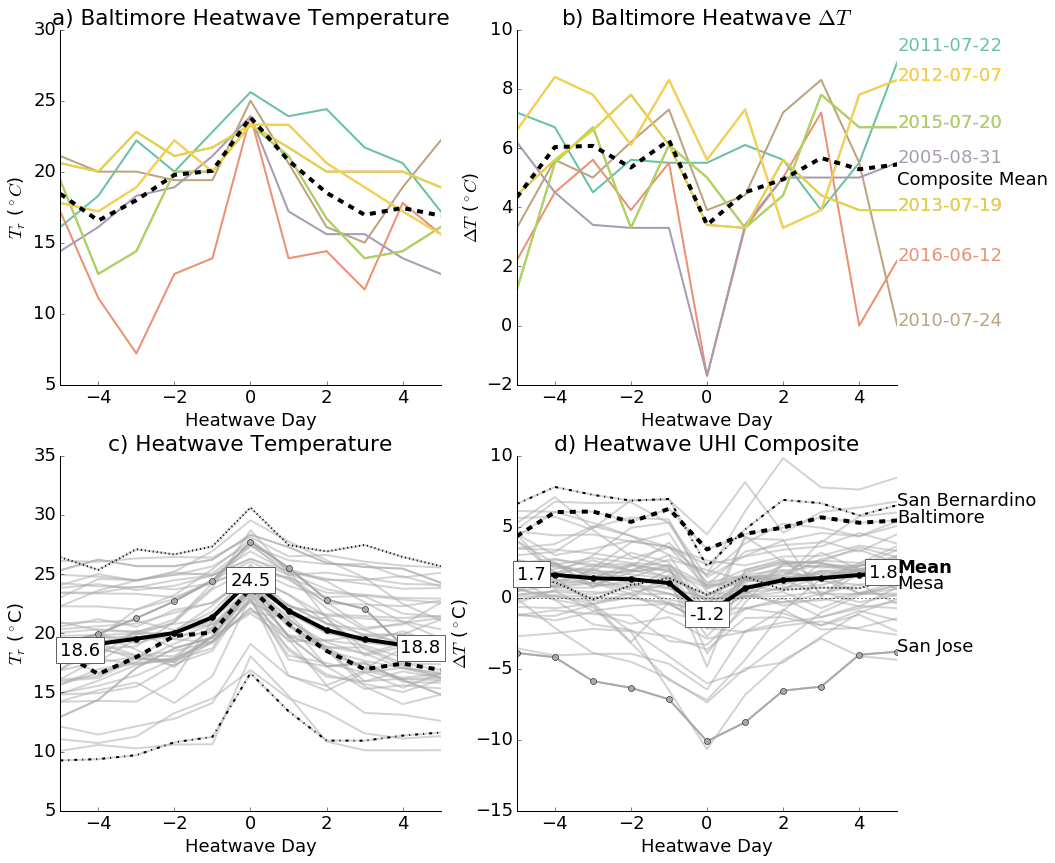

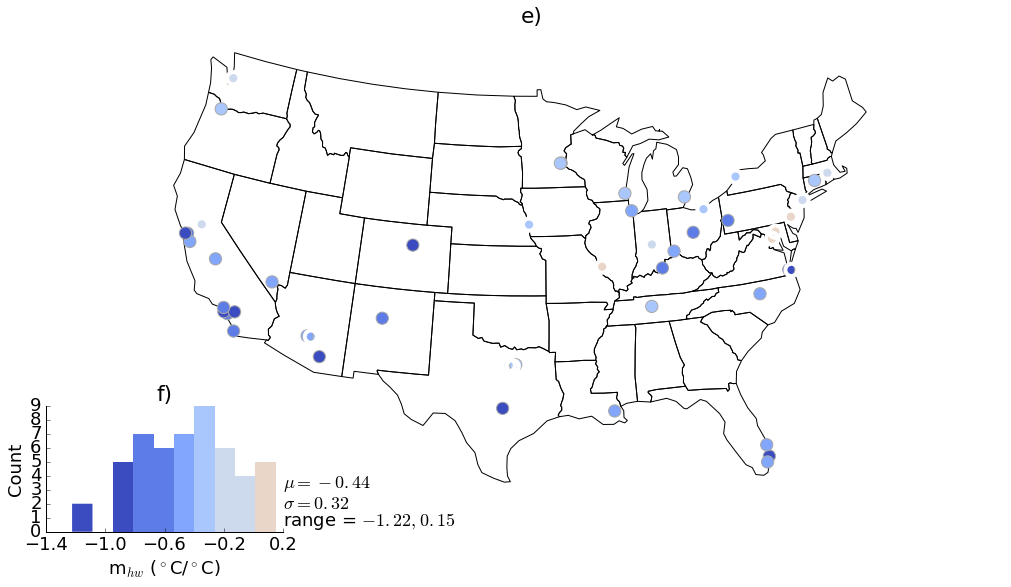

In [327]:
# Figure 2) heatwaves figure
# Figure 2, heatwave figure

# # import data 
x = np.arange(-5,6,1)

compositeTempDF = pd.read_csv(results_filepath+'composite_temp.csv').set_index('City')
compositeTempDF.columns = x

compositeUHIDF = pd.read_csv(results_filepath+'composite_UHI.csv').set_index('City')
compositeUHIDF.columns = x
# i= 20 #range(52, paired_df.shape[0]): 
# city = paired_df.iloc[i]['City']
# city = unicode(city, errors = 'ignore')
# urbanID = paired_df.iloc[i]['Urban station']
# ruralID = paired_df.iloc[i]['Rural station']
# print city
#     # Downloadd from NCDC the station data, using the station ID listed in station list
# urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
#                                      as_dataframe=True, update = False)
# ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
#                                      as_dataframe=True, update = False)
# rural_tmin = pd.to_numeric(ruraldata['TMIN']['2005-06-01':].value/10.) #rural tmin
# urban_tmin = pd.to_numeric(urbandata['TMIN']['2005-06-01':].value/10.)        
# # extract summertime data 
# rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
# urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

# # clean data: eliminate min temperatures below 4 or above 35
# rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
# urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

# #calculate UHI
# UHI = urban_summer - rural_summer

#         ######        
# hottestmin = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] 
# minheatwaves = hottestmin[0:12]
        
# ### make sure that heatwaves aren't duplicates
# Ns = []
# m = 0 
# for n in range(1,11): 
#     old = m
#     try: 
#         while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
#             m = m+1
#     except IndexError: 
#         minheatwaves = hottestmin[0:20]
#         try: 
#             while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
#                 m = m+1
#         except IndexError: 
#             print('out of bounds')
#     try: 
#         if old ==m : 
#             Ns.append(minheatwaves.sort_index().index[m])
#         else: 
#             Ns.append(minheatwaves.sort_index()[old:m].argmax())
#     except: 
#         'random error'
#     m = m+1
# finalhw = hottestmin[Ns].sort_values(ascending=False)

# # calculate composite heatwave events
# heatwaves = finalhw
# compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
# compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
# ii = 0
# for dates in heatwaves.index: 
#     compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
#     compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
#     ii = ii+1

# plot
plt.figure(figsize=[15,14])
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))
bmorec = 'k'
plt.subplot(2,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s Heatwave Temperature'%(city))
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
#plt.legend(legend_str,loc = 2)
prettify_plot()

plt.subplot(2,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s Heatwave $\Delta T$'%(city))
plt.ylabel('$\Delta T $ ($ ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()
i = 0

for date in heatwaves.index: 
    if i ==0 : 
        plt.text(5, compositeUHI[i][10]+.4, date, color = tHandle[i].get_color()) # 1994-08-03
    else: 
         plt.text(5, compositeUHI[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    i = i+1
plt.text(5,np.nanmean(compositeUHI, axis=0)[9]-.5, 'Composite Mean', color = 'black')

# plot heatwave composites for all stations
#plot temperature,raw
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
#plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeTempDF.loc['Mesa'], ':', color = 'k', alpha = 1, linewidth = 2, label = 'Mesa')
plt.plot(x, compositeTempDF.loc['San Bernardino'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'San Bernadino')
plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')


plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heatwave Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) Heatwave Temperature')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')
prettify_plot()

#plot UHI, raw
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('d) Heatwave UHI Composite')
prettify_plot()

xx = -5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][5],'%s'%compositeUHIDF.mean(axis=1).argmin())
plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][5],'%s'%compositeUHIDF.mean(axis=1).argmax())
plt.text(5,compositeUHIDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
plt.text(5,compositeUHIDF.loc['Mesa'][4],'Mesa', color = 'k')
plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')


plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
#plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeUHIDF.loc['Mesa'], ':', color = 'k', alpha = 1, linewidth = 2, label = 'Mesa')
plt.plot(x, compositeUHIDF.loc['San Bernardino'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'San Bernadino')
plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

#plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5)) 
plt.savefig(results_filepath+ 'hwcompositeTMIN.pdf',bbox_inches='tight')

# Heatwave map
# note: c_insignificant = results_df[results_df['hw P-value']>0.05] but this data seems to not be saved? check older versions of file
#drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df['hw Slope'].loc[cities]#.drop(drop_cities) #slopes

fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Average Heatwaves',# ''$\Delta T$ sensitivity to average heatwaves temp. change', 
                    data_label='m$_{hw}$ ($^\circ$C/$^\circ$C)', 
                   c_insignificant = results_df[results_df['hw P-value']>0.05]) 
ax.set_title('e)')
sub_ax.set_title('f)')
sub_ax.set_xticks(sub_ax.get_xticks()[::2])
sub_ax.set_yticks(sub_ax.get_xticks()[::2])

# for tick in sub_ax.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(14) 
plt.savefig(results_filepath+ 'avghwslopemap.pdf', bbox_inches='tight')

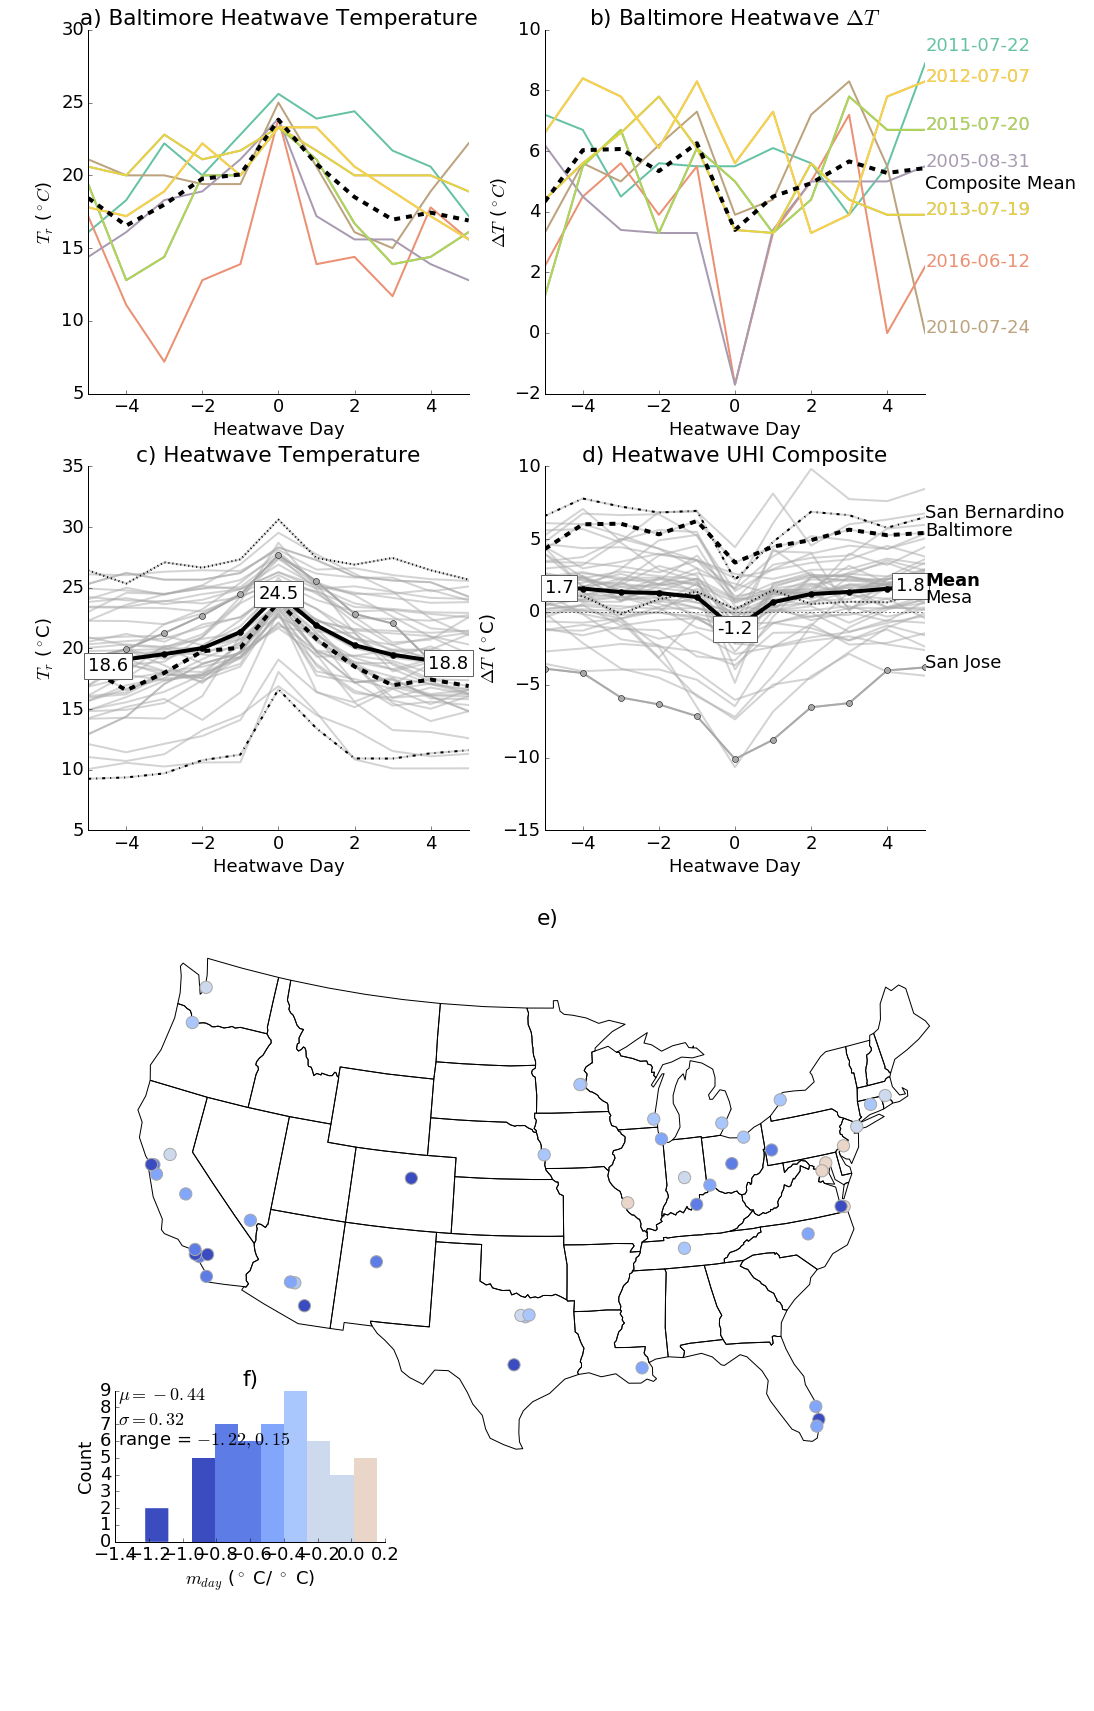

In [398]:
#heatwaves plot all in one figure : need to include significance, though
plt.figure(figsize=[15,30])
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))
bmorec = 'k'

# a) 
plt.subplot2grid((4,2), (0,0))

tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s Heatwave Temperature'%(city))
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()

#b)
plt.subplot2grid((4,2), (0,1))
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s Heatwave $\Delta T$'%(city))
plt.ylabel('$\Delta T $ ($ ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()
i = 0

for date in heatwaves.index: 
    if i ==0 : 
        plt.text(5, compositeUHI[i][10]+.4, date, color = tHandle[i].get_color()) # 1994-08-03
    else: 
         plt.text(5, compositeUHI[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    i = i+1
plt.text(5,np.nanmean(compositeUHI, axis=0)[9]-.5, 'Composite Mean', color = 'black')

# plot heatwave co
# c) 
plt.subplot2grid((4,2), (1,0))


for i in range(0, compositeTempDF.shape[0]) : 
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
#plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeTempDF.loc['Mesa'], ':', color = 'k', alpha = 1, linewidth = 2, label = 'Mesa')
plt.plot(x, compositeTempDF.loc['San Bernardino'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'San Bernadino')
plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')


plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heatwave Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) Heatwave Temperature')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')
prettify_plot()


#d)
plt.subplot2grid((4,2), (1,1))

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('d) Heatwave UHI Composite')
prettify_plot()

xx = -5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][5],'%s'%compositeUHIDF.mean(axis=1).argmin())
plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][5],'%s'%compositeUHIDF.mean(axis=1).argmax())
plt.text(5,compositeUHIDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
plt.text(5,compositeUHIDF.loc['Mesa'][4],'Mesa', color = 'k')
plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')


plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
#plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeUHIDF.loc['Mesa'], ':', color = 'k', alpha = 1, linewidth = 2, label = 'Mesa')
plt.plot(x, compositeUHIDF.loc['San Bernardino'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'San Bernadino')
plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')


# e) 
map_ax = plt.subplot2grid((4,2), (2,0), colspan = 2, rowspan=2)#, projection=ccrs.LambertConformal())
prettify_plot()
map_ax.spines['left'].set_color('none')
map_ax.spines['bottom'].set_color('none')
map_ax.spines["left"].set_visible(False)  
map_ax.spines["bottom"].set_visible(False)
map_ax.set_xticklabels([])
map_ax.set_yticklabels([])
map_ax.set_xticks([])
map_ax.set_yticks([])

ax = plt.axes([.05, -.15, 1, 1],
                     projection=ccrs.LambertConformal())
# ax = plt.axes([0, 0, 1, 1],
#                     projection=ccrs.LambertConformal())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)
# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# Plot background state map
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor = 'None'#[0.9375, 0.9375, 0.859375]
    edgecolor = 'black'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

# define data
cities =paired_df[paired_df['Urban distance']< 0.2].index#
data = results_df['hw Slope'][cities]
data = data[~np.isnan(data)]
# Set up colors for plotting
c = data
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
#ax.set_position(ax.get_position().bounds + np.array([0,0.5, 0,0]))
plt.title('e)')
prettify_plot()
# f) histogram 

sub_ax = plt.axes([0.15,0.2, 0.25, 0.07])#plt.subplot2grid((3,3), (0,3))
n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
# annotate and label 
sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(0.01, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(0.01, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(0.01, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.set_xlabel('$m_{day}$ ($^\circ$ C/ $^\circ$ C)')#data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
sub_ax.set_ylabel('Count')
sub_ax.set_title('f)')
m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
m._A = []
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
    plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
prettify_plot()
#plt.tight_layout()
#plt.savefig(results_filepath+ 'Fig2heatwaves.pdf', bbox_inches='tight')

In [551]:
# increase in Tr over heatwave
compositeTempDF.loc['Baltimore'][0] - compositeTempDF.loc['Baltimore'][-4]

7.2699999999999996

In [549]:
# decrease in DT over heatwave
compositeUHIDF.loc['Baltimore'][-4] - compositeUHIDF.loc['Baltimore'][0]

2.6300000000000003

In [562]:
# This is enough to reduce DT to below zero in all but: 
compositeUHIDF[compositeUHIDF[0] <0].shape
# cities

(30, 11)

In [563]:
compositeTempDF.shape

(51, 11)

In [411]:
#         pd.DataFrame(trend_results, columns = cols).to_csv(results_filepath+'30yrtrend/trend_results.csv')
trend_resultDF = pd.read_csv(results_filepath+'30yrtrend/trend_results.csv').set_index(pd.read_csv('USpairs2005-2015.csv')['City']).loc[paired_df.index]#.drop(2).set_index(pairs.drop(2)['City']).drop(drop_cities)

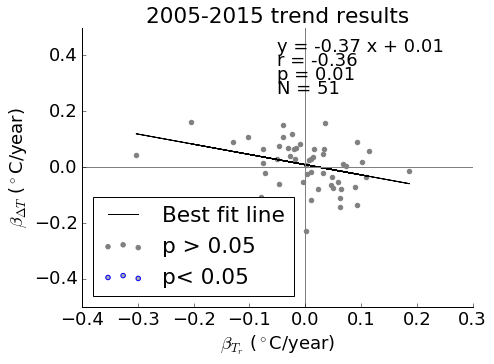

In [413]:
# # Figure 3) don't include this for short_period
# trend_resultDF = pd.read_csv(results_filepath+'30yrtrend/trend_results.csv')#.drop(2).set_index(pairs.drop(2)['City']).drop(drop_cities)
# # load error bars
# results_filepath_error_bars = 'plots/version2/UHIvariance/' 
# cities = paired_df['City'].values
# slopes_std = []
# for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
#     city = paired_df.iloc[i]['City']
#     if city == 'Grand Prairie': 
#         city = 'Arlington'
#     try: 
#         array = np.load(results_filepath_error_bars+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
#         array = array[~np.isnan(array)]
#         slopes_std.append(array.std())
#     except IOError: 
#         print('Skipping %s'%city)

x = trend_resultDF['Annual Temp Slope']
y =  trend_resultDF['Annual UHI Slope']
plt.figure(figsize=[7,5])
# plt.errorbar(x, y, yerr = slopes_std, fmt='o', alpha = .5,#markersize='10', 
#              color = 'DarkGray', zorder =0)

m, r, p = hw_scatter(trend_resultDF['Annual Temp Slope'], trend_resultDF['Annual UHI Slope'],
           '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{\Delta T}$ ($^\circ$C/year)')

plt.scatter(trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual Temp Slope'], 
           trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual UHI Slope'], 
           color = 'darkgray', edgecolor = 'blue', zorder =1)

plt.legend(['Best fit line', 'p > 0.05', 'p< 0.05'], loc = 3)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.ylim([-0.5,.5])
plt.title('2005-2015 trend results')
prettify_plot()
plt.savefig(results_filepath+'30yeartrend.pdf', bbox_inches='tight')
# print(p)

In [418]:
# how many of these rural trends are stat. significant? 
trend_resultDF[(trend_resultDF['Temp p-value'] < .05) ].shape

(4, 11)

In [419]:
# how many of these UHI trends are stat. significant
trend_resultDF[trend_resultDF['UHI p-value']<.05].shape

(11, 11)

0.00240919736979


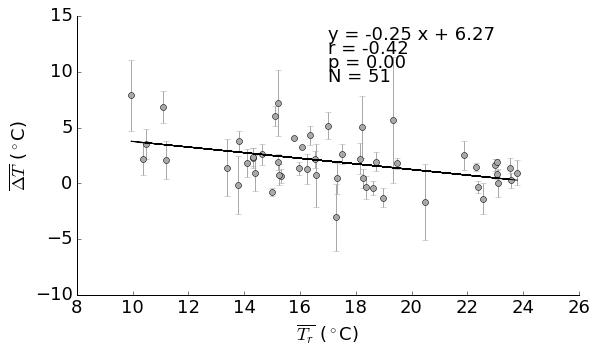

In [243]:
# Figure 4) spatial variability or do hotter cities have lower UHI? 
# load error bars
#results_filepath_error_bars = 'plots/version2/UHIvariance/' 
results_filepath_error_bars = 'plots/version5/UHIvariance/' 
cities = paired_df['City'].values
UHI_std = []
missing_cities = []
#for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
for city in cities: 
    #city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy')
        array = array[~np.isnan(array)]
        UHI_std.append(array.std())
    except IOError: 
        print('Skipping %s'%city)
        missing_cities.append(city)
        
plt.figure(figsize=[9,5])
x = results_df['Mean JJA Rural Temp'].loc[cities]
y = results_df['Mean UHI'].loc[cities]
plt.errorbar(x, y, yerr = UHI_std, fmt='o', color = 'DarkGray')
m,r,p = hw_scatter(x,y,
             '', 
             '$\overline{T_r}$ ($^\circ$C)', '$\overline{\Delta T}$ ($^\circ$C)')
prettify_plot()
plt.savefig(results_filepath+ 'meantempvsmeanUHI.pdf',bbox_inches='tight')
print(p)

In [430]:
# compute anomaly analysis
#!mkdir plots/version5/2005pairs/anomalyJJA
#!mkdir plots/version5/2005pairs/summermeans
# anomaly_results1 = np.nan*np.ones([paired_df.shape[0], 3])
# mean_summer_tvsdt = np.nan*np.ones([paired_df.shape[0], 3])
toc = time.time() #time
anomaly_results = np.nan*np.ones([paired_df.shape[0], 3])
mean_summer_tvsdt = np.nan*np.ones([paired_df.shape[0], 3])
for i in range(0, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['2005-06-01':].index, ruraldata['TMIN']['2005-06-01':].index).shape[0] > 300): 
        ######
        ###### Import data
        ######
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['2005-06-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['2005-06-01':].value/10.) 
                
        # extract summertime data 
#         rural_summer = rural_tmin[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)]
#         urban_summer = urban_tmin[np.logical_or(urban_tmin.index.month==6, urban_tmin.index.month==7, urban_tmin.index.month==8)]
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
        
        # clean data: eliminate min temperatures below 4 or above 35
        rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
        urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]
        
        #calculate UHI
        UHI = urban_summer - rural_summer
        # calculate anomalies 
        clim = rural_summer.groupby(rural_summer.index.year).mean()
        x = rural_summer - clim[rural_summer.index.year].values # anomaly temperature
        clim_deltaT = UHI.groupby(UHI.index.year).mean()
        y = UHI - clim_deltaT[UHI.index.year].values # anomaly UHI
        ind = ~np.isnan(y) & ~np.isnan(x)
        # plot daily T' vs Delta T'
        m,r,p = color_scatter(x[ind], y[ind], '%s JJA Anomaly Temp versus $\Delta T$'%city, 'Anomaly T ($^\circ$C)', 'Anomaly $\Delta T$ ($ ^\circ$ C)')
        plt.savefig(results_filepath+ 'anomalyJJA/'+'JJAUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
        plt.close()        
        anomaly_results1[i,:] = m,r,p
                #save out
        # plot summer mean values against each other 
        x = rural_summer.groupby(rural_summer.index.year).mean()
        y = UHI.groupby(UHI.index.year).mean()
        ind = ~np.isnan(y) & ~np.isnan(x)

        m,r,p = color_scatter_years(x[ind], y[ind], 
                      '%s Summer Mean JJA Temp versus Summer Mean$\Delta T$'%city, 
                      '$T_r$ ($^\circ$C)', 
                      '$\Delta T$ ($ ^\circ$ C)')
        plt.savefig(results_filepath+ 'summermeans/'+'summermeanTvDT%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
        plt.close()        
        mean_summer_tvsdt[i,:] = m,r,p

        if np.mod(i,10) == 0 : 
            pd.DataFrame(anomaly_results1, columns= ['Anomaly m', 'Anomaly r', 'Anomaly p'], index = paired_df.index).to_csv(results_filepath+'anomalyJJA/'+'anomaly_results1.csv')
            pd.DataFrame(mean_summer_tvsdt, columns= ['m', 'r', 'p-value'], index = paired_df.index).to_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv')            

pd.DataFrame(anomaly_results1, columns= ['Anomaly m', 'Anomaly r', 'Anomaly p'], index = paired_df.index).to_csv(results_filepath+'anomalyJJA/'+'anomaly_results1.csv')
pd.DataFrame(mean_summer_tvsdt, columns= ['m', 'r', 'p-value'], index = paired_df.index).to_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv')            

# pd.DataFrame(anomaly_results, columns= ['Anomaly m', 'Anomaly r', 'Anomaly p']).to_csv(results_filepath+'anomalyJJA/'+'anomaly_results.csv')
# pd.DataFrame(mean_summer_tvsdt, columns= ['m', 'r', 'p-value']).to_csv(results_filepath+'summermeans/'+'mean_summer_tvsdt_results.csv')
#anomaly_results = pd.read_csv(results_filepath+'anomalyJJA/'+'anomaly_results.csv')

Mesa
Grand Prairie
Irvine
Fort Lauderdale
Long Beach
Hartford
Providence
Virginia Beach
Oakland
West Palm Beach
Louisville
Columbus
San Bernardino
St. Paul
Tucson
Fresno
Albuquerque
Ft. Worth
Austin
Indianapolis
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Omaha
Raleigh
Cleveland
Cincinnati
Nashville
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Philadelphia
Detroit
San Francisco
Denver
Miami
Chicago
Los Angeles
Washington, D.C.
New York


In [420]:
results_filepath

'plots/version5/2005pairs/'

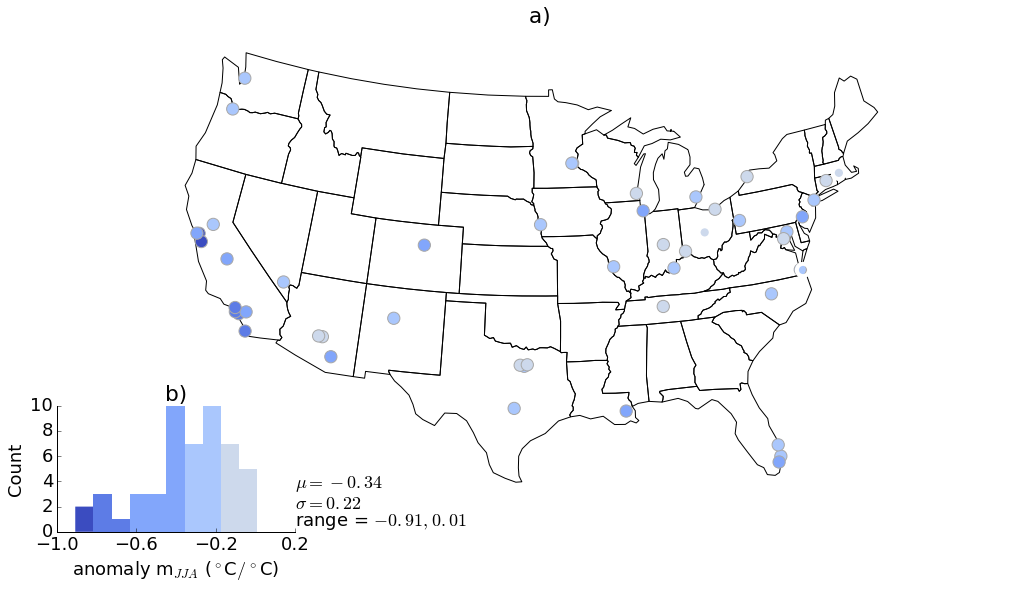

In [444]:
# read in anomaly data
anomaly_results = pd.read_csv(results_filepath+'anomalyJJA/'+'anomaly_results1.csv').set_index(paired_df.index)#.loc[results_df.index]
data = anomaly_results['Anomaly m']#.drop(drop_cities, axis = 0)['Anomaly m']
fig= map_hist_plot(data, paired_df, title = 'Response of Anomaly $\Delta T$ to Temperature Change', 
                    data_label = 'anomaly m$_{JJA}$ ($^\circ$C$ / ^\circ $C)', 
                   c_insignificant = anomaly_results[anomaly_results['Anomaly p']>0.05]) 
plt.savefig(results_filepath+ 'anomalyJJAslopes.pdf', bbox_inches='tight')

In [535]:
uhiswx = pd.read_csv('plots/version5/ssc/'+ 'sscanalysis.csv').set_index('City').loc[paired_df.index]# read in synoptic weather results
ruralswx = pd.read_csv('plots/version5/ssc/'+ 'rural_sscanalysis.csv').set_index('City').loc[paired_df.index]# read in synoptic weather results
urbanswx = pd.read_csv('plots/version5/ssc/'+ 'urban_sscanalysis.csv').set_index('City').loc[paired_df.index]# read in synoptic weather results

# ruralswx['Dry UHI'] = ruralswx[['DM', 'DP', 'DT']].mean(axis=1)
# ruralswx['Moist UHI'] = ruralswx[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
# uhiswx['Dry UHI'] = uhiswx[['DM', 'DP', 'DT']].mean(axis=1)
# uhiswx['Moist UHI'] = uhiswx[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)

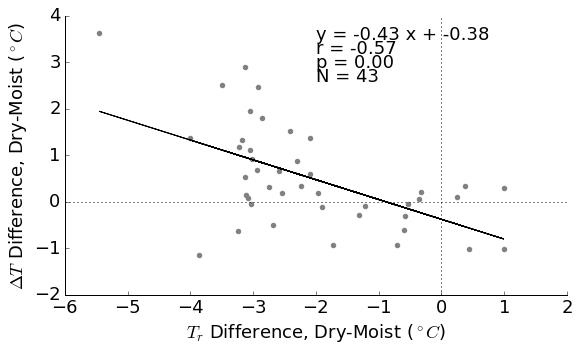

In [593]:
# Sup Figure: relationship of synoptic weather 
# uhiswx = pd.read_csv('plots/version5/ssc/'+ 'sscanalysis.csv').set_index('City').loc[paired_df.index]# read in synoptic weather results
# ruralswx = pd.read_csv('plots/version5/ssc/'+ 'rural_sscanalysis.csv').set_index('City').loc[paired_df.index]# read in synoptic weather results

# ruralswx['Dry UHI'] = ruralswx[['DM', 'DP', 'DT']].mean(axis=1)
# ruralswx['Moist UHI'] = ruralswx[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
# uhiswx['Dry UHI'] = uhiswx[['DM', 'DP', 'DT']].mean(axis=1)
# uhiswx['Moist UHI'] = uhiswx[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)

# uhiswx = uhiswx[uhiswx['DM'] != 0]
# ruralswx = ruralswx[ruralswx['DM']!=0]
uhiswx = pd.read_csv('plots/version5/ssc/'+ 'sscanalysis.csv').set_index('City').loc[paired_df.index]# read in synoptic weather results
ruralswx = pd.read_csv('plots/version5/ssc/'+ 'rural_sscanalysis.csv').set_index('City').loc[paired_df.index]# read in synoptic weather results
urbanswx = pd.read_csv('plots/version5/ssc/'+ 'urban_sscanalysis.csv').set_index('City').loc[paired_df.index]# read in synoptic weather results

x = ruralswx['Dry UHI']- ruralswx['Moist UHI'] #
y = uhiswx['Dry UHI']- uhiswx['Moist UHI'] #
plt.figure(figsize=[9,5])
hw_scatter(x,y, '', '$T_r$ Difference, Dry-Moist ($^\circ C$)', '$\Delta T$ Difference, Dry-Moist ($^\circ C$)')
plt.axhline(0, linestyle = ':', color = 'k')
plt.axvline(0, linestyle = ':', color = 'k')
prettify_plot()
plt.savefig(results_filepath+ 'synopticwx.pdf', bbox_inches='tight')

In [583]:
ind = ~np.isnan(y) & ~np.isnan(x)

In [587]:
if type(ind) != 'numpy.ndarray': 
    ind= ind[ind]
ind.shape

(43,)

In [582]:
type(ind)

pandas.core.series.Series

In [580]:
ind.

(51,)

In [574]:
y[~np.isnan(y)].shape

(43,)

In [571]:
x[~np.isnan(x)].shape

(43,)

In [569]:
uhiswx[~uhiswx['DM'].isnull()].shape

(43, 9)

In [540]:
x.mean(), y.mean()

(-2.0862376644837206, 0.5125553750069599)

In [545]:
results_filepath

'plots/version5/2005pairs/'

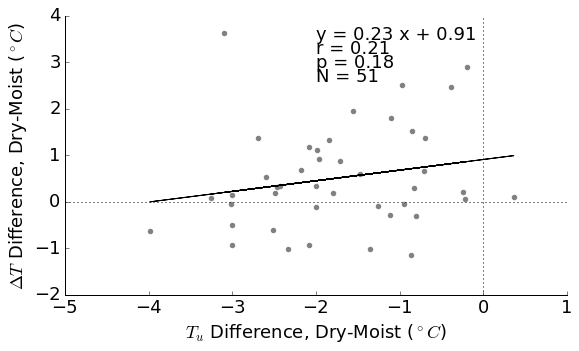

In [543]:
x = urbanswx['Dry UHI']- urbanswx['Moist UHI'] #
y = uhiswx['Dry UHI']- uhiswx['Moist UHI'] #
plt.figure(figsize=[9,5])
hw_scatter(x,y, '', '$T_u$ Difference, Dry-Moist ($^\circ C$)', '$\Delta T$ Difference, Dry-Moist ($^\circ C$)')
plt.axhline(0, linestyle = ':', color = 'k')
plt.axvline(0, linestyle = ':', color = 'k')
prettify_plot()
plt.savefig(results_filepath+ 'synopticwx_urban.pdf', bbox_inches='tight')

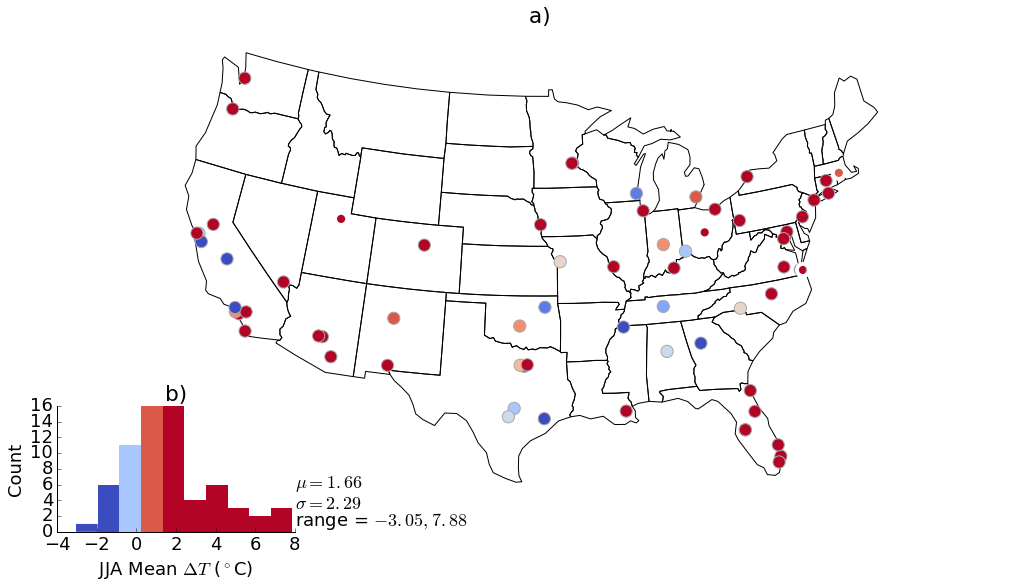

In [39]:
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df['Mean UHI']#.drop(drop_cities, axis = 0)
fig = map_hist_plot(data, paired_df, title = 'Mean UHI', 
                    data_label = 'JJA Mean $\Delta T$ ($^\circ$C)', 
                   c_insignificant = results_df[results_df['P-value']>0.05]) 
plt.savefig(results_filepath+ 'meanUHI.pdf', bbox_inches='tight')

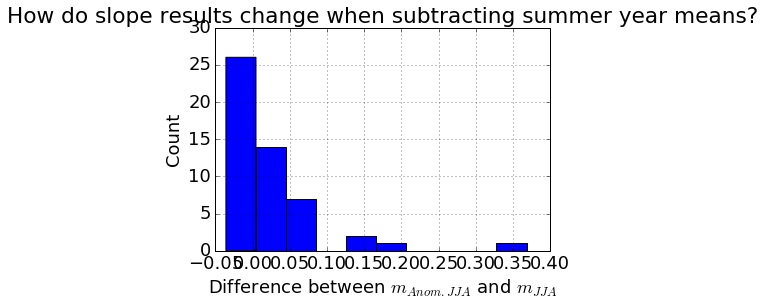

In [94]:
anomaly_results = pd.read_csv(results_filepath+'anomalyJJA/'+'anomaly_results1.csv').set_index(paired_df['City'])
(anomaly_results['Anomaly m']- results_df['Slope']).hist()
plt.ylabel('Count')
plt.xlabel('Difference between $m_{Anom. JJA}$ and $m_{JJA}$')
plt.title('How do slope results change when subtracting summer year means?')

/Users/annascott2/anaconda2/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


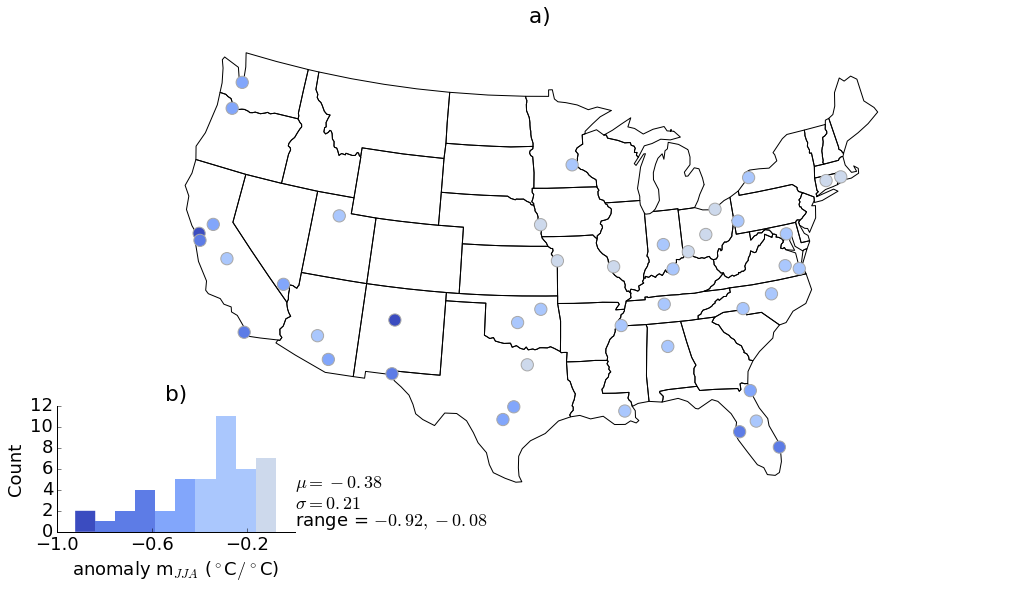

In [102]:
data = anomaly_results['Anomaly m']#.drop(drop_cities, axis = 0)['Anomaly m']
fig = map_hist_plot(data, paired_df, title = 'Response of Anomaly $\Delta T$ to Temperature Change', 
                    data_label = 'anomaly m$_{JJA}$ ($^\circ$C$ / ^\circ $C)', 
                   c_insignificant = anomaly_results[anomaly_results['Anomaly p']>0.05]) 
plt.savefig(results_filepath+ 'anomalyJJAslopes.pdf', bbox_inches='tight')

In [7]:
# results_df = pd.read_csv(results_filepath + results_filename).drop(1).set_index('City')
# results_df = results_df[results_df['Data points']>0]

In [16]:
#paired_df[paired_df['Urban distance']< 0.2].drop(['Mesa','Irvine', 'Grand Prairie', 'Virginia Beach', 'St. Paul' , 'Oakland']).index

In [17]:
results_filepath

'plots/version5/2005pairs/'

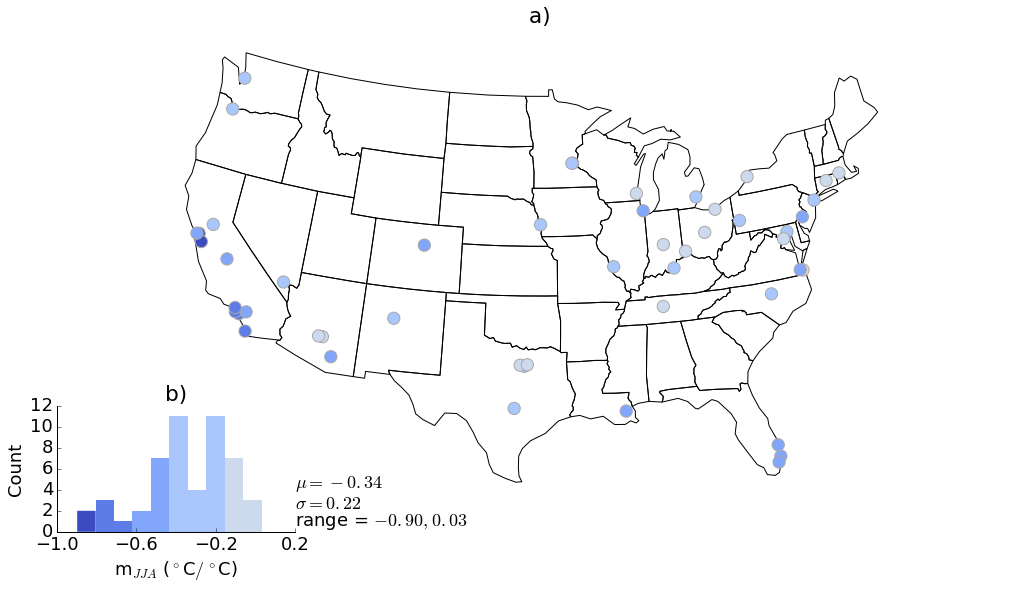

In [19]:
cities =paired_df[paired_df['Urban distance']< 0.2].index#
data = results_df['Slope'][cities]#.drop(drop_cities, axis = 0)['Slope'] #slopes
fig = map_hist_plot(data, paired_df) 
plt.savefig(results_filepath+ 'JJAslopes.pdf', bbox_inches='tight')

Baltimore
Miami


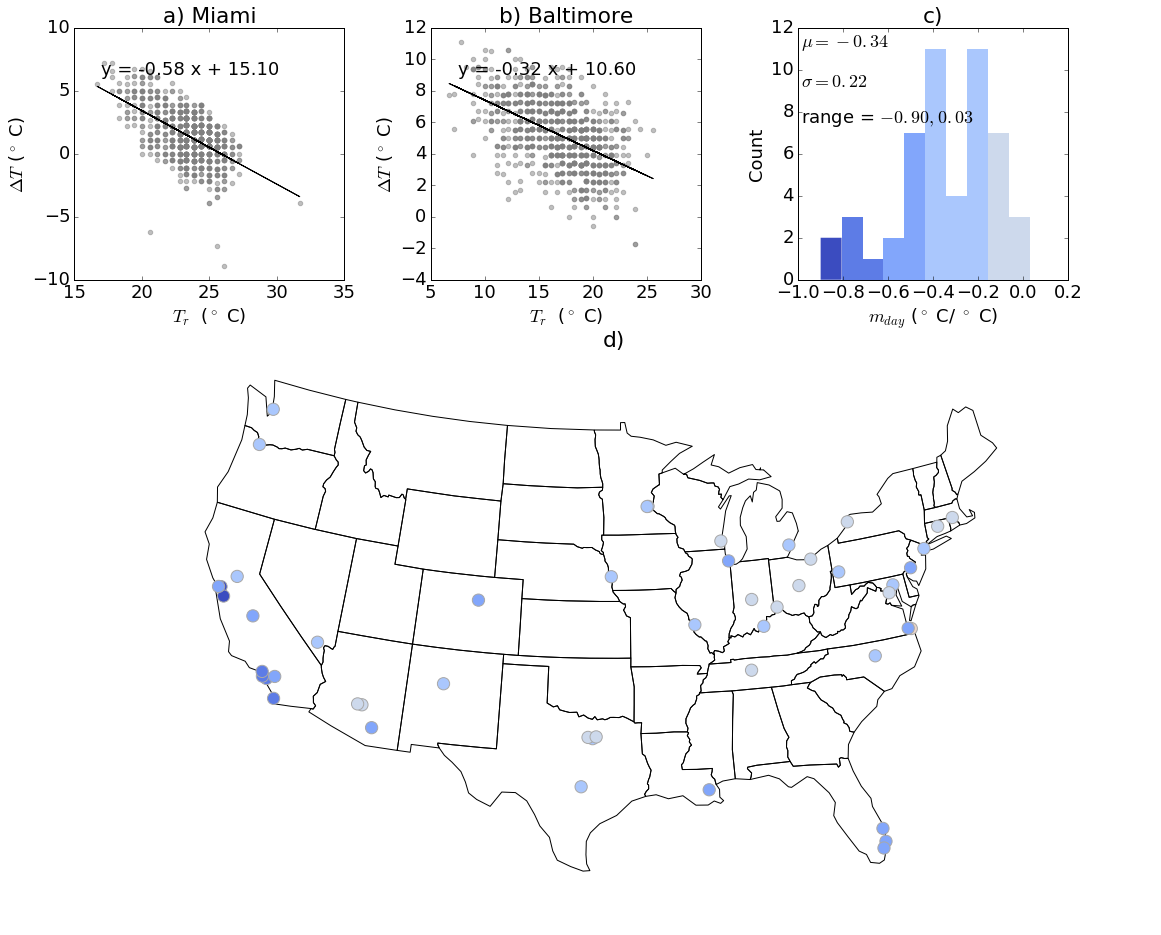

In [21]:
### map plot

def inset_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey', alpha = .5)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.1, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
#     plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

fig = plt.figure(figsize=[15,10])
#ax = fig.add_subplot(224, projection=ccrs.LambertConformal())
ax = plt.axes([0, 0, 1, 1],
                    projection=ccrs.LambertConformal())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# Plot background state map
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor = 'None'#[0.9375, 0.9375, 0.859375]
    edgecolor = 'black'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, zorder = 0)

# define data
cities =paired_df[paired_df['Urban distance']< 0.2].index#
data = results_df['Slope'][cities]
#data = results_df['Slope']
data = data[~np.isnan(data)]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = ax.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        transform=ccrs.Geodetic(), edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.title('d)')

######
dummy_ind = 0
#for i in [15, 19]: 
for city in ['Baltimore', 'Miami']:
    # = paired_df.loc[i]['City']
    #city = unicode(city, errors = 'ignore')
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    ######
    ###### Import data
    ######
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['2005-06-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['2005-06-01':].value/10.)         
    # extract summertime data 
    rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
    urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]
    # clean data: eliminate min temperatures below 4 or above 35
    rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
    urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

    #calculate UHI
    UHI = urban_summer - rural_summer
    if dummy_ind ==0 : 
        #sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])
        sub_ax2 = plt.axes([0.33, 1.0, 0.25, 0.35])

        #sub_ax3 = plt.axes([0.9, 0.0, 0.25, 0.35])
        inset_scatter(rural_summer[UHI.index], UHI,'b) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 
    else: 
        sub_ax1 = plt.axes([0.0, 1.0, 0.25, 0.35])

        #sub_ax2 = plt.axes([0.9, 0.6, 0.25, 0.35])
        inset_scatter(rural_summer[UHI.index], UHI,'a) %s'%(city),
                  '$T_r$  ($^\circ$ C)', '$\Delta T$ ($^\circ$ C)') 
    ##### Inset plot     
    dummy_ind = dummy_ind+1
    


sub_ax = plt.axes([0.67, 1.0, 0.25, 0.35])#plt.subplot2grid((3,3), (0,3))
n, bins, patches = sub_ax.hist(data,10, facecolor = 'darkgray', linewidth=0)
# annotate and label 
sub_ax.annotate('$ \mu = %2.2f $'%data.mean(), xy=(0.01, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('$ \sigma  = %2.2f $'%data.std(), xy=(0.01, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.annotate('range = $%2.2f, %2.2f $'%(data.min(), data.max()), xy=(0.01, .6), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
sub_ax.set_xlabel('$m_{day}$ ($^\circ$ C/ $^\circ$ C)')#data_label) #'m$_{JJA}$ ($^\circ$C$ / ^\circ $C)')
sub_ax.set_ylabel('Count')
sub_ax.set_title('c)')

# set colors 
m = matplotlib.cm.ScalarMappable(norm = norm, cmap = cmap)
m._A = []

bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c,p in zip(bin_centers, patches): # in range(np.size(patches)):
    plt.setp(p,'facecolor', m.to_rgba(c))#color=m.to_rgba(c))
plt.savefig(results_filepath+ 'fullJJAslopes.pdf', bbox_inches='tight')

In [63]:
# load error bars
#results_filepath_error_bars = 'plots/version2/UHIvariance/' 
results_filepath_error_bars = 'plots/version5/UHIvariance/' 
cities = paired_df['City'].values
UHI_std = []
missing_cities = []
#for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
for city in cities: 
    #city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy')
        array = array[~np.isnan(array)]
        UHI_std.append(array.std())
    except IOError: 
        print('Skipping %s'%city)
        missing_cities.append(city)
        
# drop #2- it's a duplicate
#del UHI_std[1]

In [64]:
missing_cities

[]

In [65]:
len(UHI_std)

51

0.00240919736979


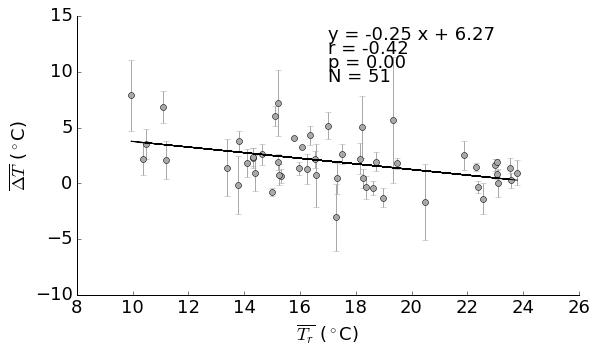

In [67]:
# hw_scatter(results_df['Mean JJA Rural Temp'],results_df['Mean UHI'],
#              'Do hotter cities have higher $\Delta T$?', 
#              '$T_r$ ($^\circ$C)', '$\overline{\Delta T}$ ($\Delta ^\circ$C)')
plt.figure(figsize=[9,5])
x = results_df['Mean JJA Rural Temp'].loc[cities]
y = results_df['Mean UHI'].loc[cities]
plt.errorbar(x, y, yerr = UHI_std, fmt='o', color = 'DarkGray')
m,r,p = hw_scatter(x,y,
             '', 
             '$\overline{T_r}$ ($^\circ$C)', '$\overline{\Delta T}$ ($^\circ$C)')
prettify_plot()
plt.savefig(results_filepath+ 'meantempvsmeanUHI.pdf',bbox_inches='tight')
print(p)

In [35]:
results_filepath

'plots/version5/2005pairs/'

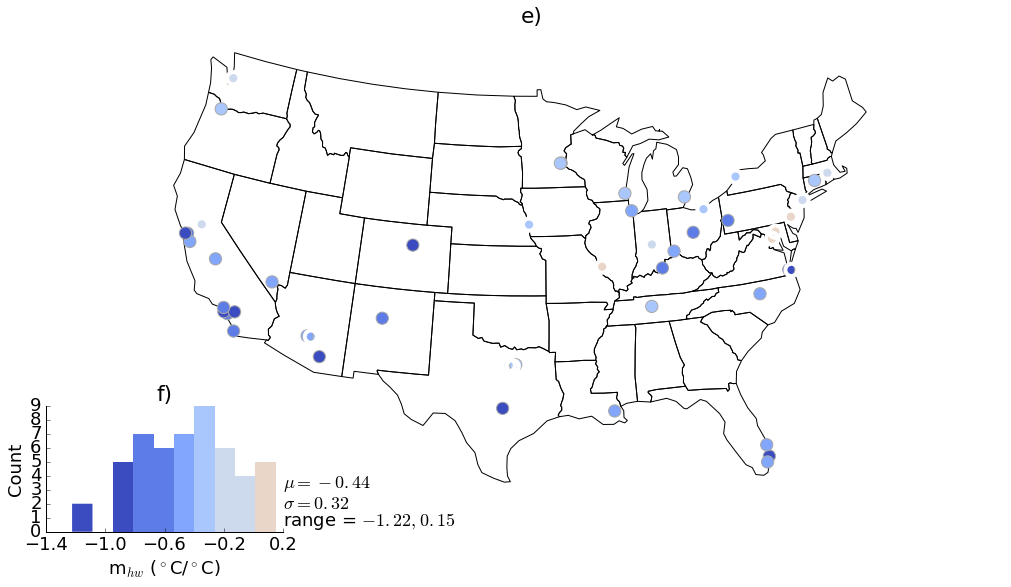

In [62]:
# Heatwave map
# note: c_insignificant = results_df[results_df['hw P-value']>0.05] but this data seems to not be saved? check older versions of file
#drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = results_df['hw Slope'].loc[cities]#.drop(drop_cities) #slopes

fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Average Heatwaves',# ''$\Delta T$ sensitivity to average heatwaves temp. change', 
                    data_label='m$_{hw}$ ($^\circ$C/$^\circ$C)', 
                   c_insignificant = results_df[results_df['hw P-value']>0.05]) 
ax.set_title('e)')
sub_ax.set_title('f)')
sub_ax.set_xticks(sub_ax.get_xticks()[::2])
# for tick in sub_ax.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(14) 
plt.savefig(results_filepath+ 'avghwslopemap.pdf', bbox_inches='tight')

In [61]:
results_filepath

'plots/version5/2005pairs/'

In [70]:
data.drop(drop_cities).shape

(63,)

In [541]:
mean_summer_tvsdt.columns

Index([u'Unnamed: 0', u'm', u'r', u'p-value'], dtype='object')

In [452]:
mean_summer_tvsdt.loc['Washington, D.C.']

Unnamed: 0    57.000000
m             -0.283249
r             -0.168241
p-value        0.365621
Name: Washington, D.C., dtype: float64

In [451]:
mean_summer_tvsdt.loc['Baltimore']

Unnamed: 0    25.000000
m             -0.508793
r             -0.587960
p-value        0.000634
Name: Baltimore, dtype: float64

In [287]:
# change over time: summer annual temps
mean_summer_tvsdt = pd.read_csv('plots/version2/'+'summermeans/'+'mean_summer_tvsdt_results.csv').drop(2).set_index(paired_df.City)

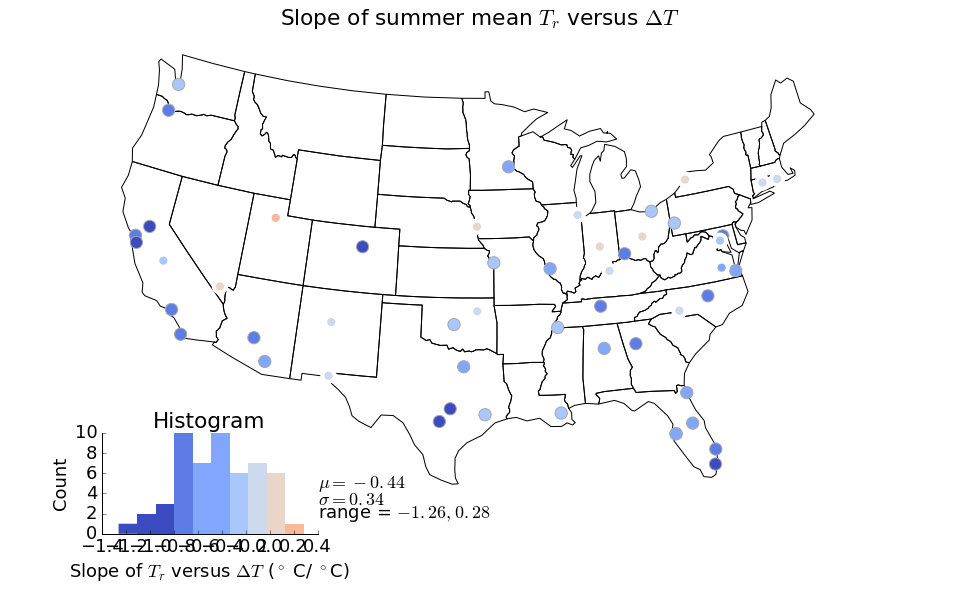

In [288]:
# change over time: summer annual temps versus UHI
mean_summer_tvsdt = pd.read_csv('plots/version2/'+'summermeans/'+'mean_summer_tvsdt_results.csv').drop(2).set_index(paired_df.City)
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = mean_summer_tvsdt.drop(drop_cities)['m']
fig = map_hist_plot(data, paired_df, title = 'Slope of summer mean $T_r$ versus $\Delta T$', 
                    data_label='Slope of $T_r$ versus $\Delta T$ ($^\circ$ C/ $^\circ $C)', 
                  c_insignificant = mean_summer_tvsdt[mean_summer_tvsdt['p-value']>0.05]) 
plt.savefig(results_filepath+ 'mean_summer_tvsdt_map.pdf', bbox_inches='tight')

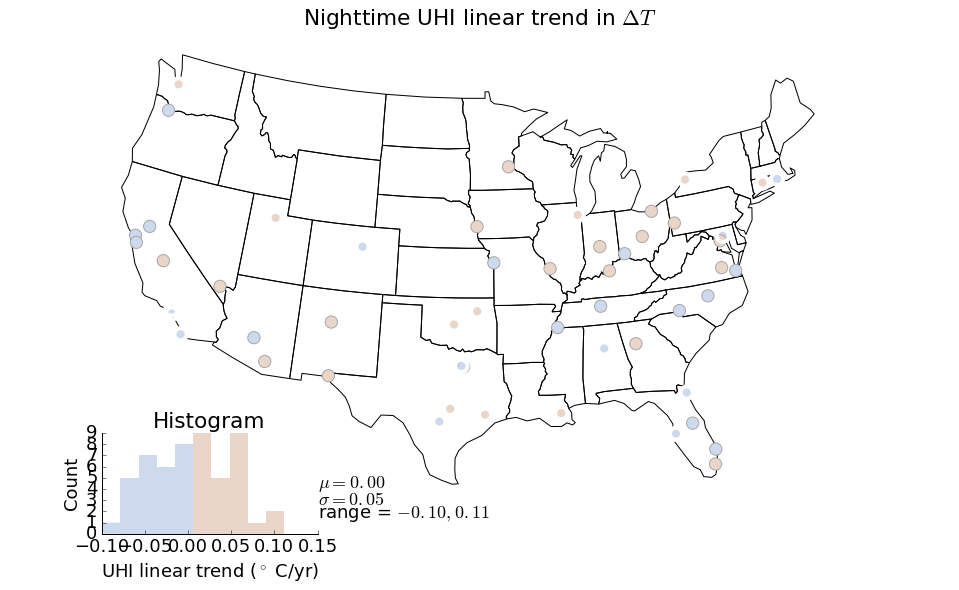

In [289]:
# linear trend in UHI
# check units- not sure if this is per year
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = mean_summer_tvsdt.drop(drop_cities)['m']
data = results_df.drop(drop_cities)['UHI linear trend']

fig = map_hist_plot(data, paired_df, title = 'Nighttime UHI linear trend in $\Delta T$', 
                    data_label='UHI linear trend ($^\circ$ C/yr)', 
                  c_insignificant = results_df[results_df['UHI linear trend p-value']>0.05]) 
plt.savefig(results_filepath+ 'UHIlineartrend.pdf', bbox_inches='tight')

In [37]:
results_df.loc[cities]['UHI linear trend'].mean()

0.007775900095548629

In [39]:
# percentage of warming cities
print((results_df.loc[cities]['UHI linear trend'] > 0).sum()/ float(results_df.loc[cities].shape[0]))
print((results_df.loc[cities]['UHI linear trend'] > 0).sum())

0.588235294118
30


In [40]:
# percentage of cooling cities
print((results_df.loc[cities]['UHI linear trend'] < 0).sum()/ float(results_df.loc[cities].shape[0]))
print((results_df.loc[cities]['UHI linear trend'] < 0).sum())

0.411764705882
21


In [53]:
results_filepath

'plots/version3/'

In [24]:
trend_resultDF = pd.read_csv(results_filepath+'30yrtrend/trend_results.csv')#.drop(2).set_index(pairs.drop(2)['City']).drop(drop_cities)

In [51]:
trend_resultDF = pd.read_csv(results_filepath+'30yrtrend/trend_results.csv')#.drop(2).set_index(pairs.drop(2)['City']).drop(drop_cities)
# load error bars
results_filepath_error_bars = 'plots/version2/UHIvariance/' 
cities = paired_df['City'].values
slopes_std = []
for i in range(0,paired_df.shape[0]): # probalby need to redo 1-15
    city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath_error_bars+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        slopes_std.append(array.std())
    except IOError: 
        print('Skipping %s'%city)

## x = trend_resultDF['Annual Temp Slope']
y =  trend_resultDF['Annual UHI Slope']
plt.figure(figsize=[7,5])
# plt.errorbar(x, y, yerr = slopes_std, fmt='o', alpha = .5,#markersize='10', 
#              color = 'DarkGray', zorder =0)

m, r, p = hw_scatter(trend_resultDF['Annual Temp Slope'], trend_resultDF['Annual UHI Slope'],
           '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{\Delta T}$ ($^\circ$C/year)')

plt.scatter(trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual Temp Slope'], 
           trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual UHI Slope'], 
           color = 'darkgray', edgecolor = 'blue', zorder =1)

plt.legend(['Best fit line', 'p > 0.05', 'p< 0.05'], loc = 3)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.ylim([-0.5,.5])
prettify_plot()
plt.savefig(results_filepath+'30yeartrend.pdf', bbox_inches='tight')
print(p)
# resize: 1 & 2 are the same
#slopes_std
# drop #2- it's a duplicate
#del slopes_std[1]

In [52]:
trend_resultDF['Annual UHI Slope'].mean()

0.004346023919132114

In [48]:
x.shape, y.shape, len(slopes_std)

((53,), (53,), 53)

## x = trend_resultDF['Annual Temp Slope']
y =  trend_resultDF['Annual UHI Slope']
plt.figure(figsize=[7,5])
# plt.errorbar(x, y, yerr = slopes_std, fmt='o', alpha = .5,#markersize='10', 
#              color = 'DarkGray', zorder =0)

m, r, p = hw_scatter(trend_resultDF['Annual Temp Slope'], trend_resultDF['Annual UHI Slope'],
           '', r'$\beta_{T_r}$ ($^\circ$C/year)', #30-year JJA Trend Relationship
           r'$\beta_{\Delta T}$ ($^\circ$C/year)')

plt.scatter(trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual Temp Slope'], 
           trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)]['Annual UHI Slope'], 
           color = 'darkgray', edgecolor = 'blue', zorder =1)

plt.legend(['Best fit line', 'p > 0.05', 'p< 0.05'], loc = 3)

plt.axhline(0, color = 'gray')
plt.axvline(0, color = 'gray')
plt.ylim([-0.5,.5])
prettify_plot()
plt.savefig(results_filepath+'30yeartrend.pdf', bbox_inches='tight')
print(p)

In [198]:
trend_resultDF['Annual Temp Slope'].describe()

count    53.000000
mean      0.035613
std       0.036743
min      -0.046287
25%       0.011031
50%       0.037478
75%       0.056343
max       0.111238
Name: Annual Temp Slope, dtype: float64

In [225]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw P-value', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

In [226]:
pd.read_csv('plots/version3/30yrtrend/trend_results.csv')['Annual UHI Slope'].describe()

count    59.000000
mean      0.000315
std       0.053060
min      -0.169198
25%      -0.035527
50%       0.000644
75%       0.041855
max       0.111211
Name: Annual UHI Slope, dtype: float64

In [199]:
trend_resultDF['Annual UHI Slope'].describe()

count    53.000000
mean      0.004346
std       0.048908
min      -0.099377
25%      -0.027453
50%       0.002383
75%       0.044496
max       0.111211
Name: Annual UHI Slope, dtype: float64

In [213]:
trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)].shape

(19, 11)

In [205]:
results_df.columns

Index([u'Unnamed: 0', u'Slope', u'Intercepts', u'Residual', u'Correlation',
       u'P-value', u'Urban start date', u'Urban end date', u'Rural start date',
       u'Rural end date', u'Data points', u'Mean UHI', u'Day of Max UHI',
       u'Mean JJA Rural Temp', u'UHI linear trend',
       u'UHI linear trend p-value', u'hw Slope', u'hw P-value', u'hw Residual',
       u'hw Correlation', u'hw Data points', u'hw Mean UHI',
       u'hw Mean JJA Rural Temp'],
      dtype='object')

In [207]:
results_df.drop(drop_cities)['UHI linear trend'].describe()

count    53.000000
mean      0.004346
std       0.048908
min      -0.099377
25%      -0.027453
50%       0.002383
75%       0.044496
max       0.111211
Name: UHI linear trend, dtype: float64

In [197]:
# number of cities experiencing warming
print((trend_resultDF['Annual Temp Slope']>0).sum(), ' out of ', trend_resultDF.shape[0])
print('or ',  100*(trend_resultDF['Annual Temp Slope']>0).sum()/ float(trend_resultDF.shape[0]), ' percent')

(46, ' out of ', 53)
('or ', 86.79245283018868, ' percent')


In [215]:
(trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] < 0).sum()

25

In [216]:
## cooling cities
(trend_resultDF['Annual Temp Slope']<0).sum()

7

In [210]:
print((trend_resultDF[trend_resultDF['Annual Temp Slope']<0]['Annual UHI Slope'] > 0).sum())

7


In [211]:
# number of points which don't fit the story: warming but UHI increasing
(trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] > 0).sum()

21

In [212]:
# how many of the insignificant cities are ones in which our story doesn't fit? 
insig_index = trend_resultDF[(trend_resultDF['Temp p-value'] < .05) & (trend_resultDF['UHI p-value']<.05)].index
not_fit_index = (trend_resultDF[trend_resultDF['Annual Temp Slope']>0]['Annual UHI Slope'] > 0).index
np.intersect1d(insig_index, not_fit_index).shape

(17,)

In [217]:
# how many cooling cities have increased UHI
(trend_resultDF[trend_resultDF['Annual Temp Slope']<0]['Annual UHI Slope'] > 0).sum()

7

In [330]:
trend_resultDF['Annual Temp Slope'].describe()

count    58.000000
mean      0.036885
std       0.041853
min      -0.047103
25%       0.006567
50%       0.033759
75%       0.059268
max       0.134933
Name: Annual Temp Slope, dtype: float64

In [331]:
trend_resultDF['Annual UHI Slope'].describe()

count    58.000000
mean      0.000152
std       0.053657
min      -0.168602
25%      -0.039665
50%       0.000293
75%       0.042268
max       0.108919
Name: Annual UHI Slope, dtype: float64

In [46]:
cols.shape

(11,)

In [76]:
cols = np.arange(-5,6)
#drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
composite_cities = pd.read_csv(results_filepath + results_filename)['City']#.loc[cities]

compositeTempDF = pd.read_csv((results_filepath + 'composite_temp.csv'), header = None, names =  cols).set_index(composite_cities).loc[cities]#.drop(drop_cities, axis = 0)
compositeUHIDF = pd.read_csv((results_filepath + 'composite_UHI.csv'), header = None, names =  cols).set_index(composite_cities).loc[cities]#.drop(drop_cities, axis = 0)

In [44]:
results_filepath

'plots/version5/2005pairs/'

In [77]:
compositeTempDF.shape, compositeUHIDF.shape

((51, 11), (51, 11))

Baltimore


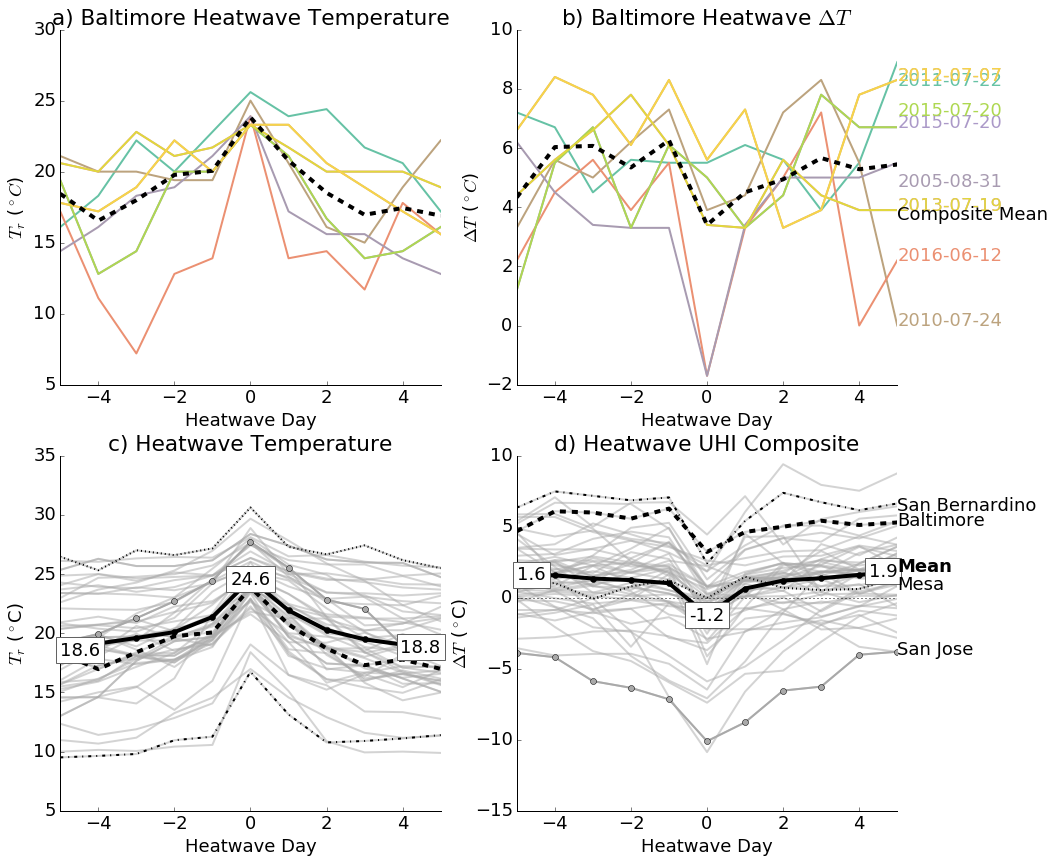

In [210]:
# Figure 2, heatwave figure

# import data 
i= 20 #range(52, paired_df.shape[0]): 
city = paired_df.iloc[i]['City']
city = unicode(city, errors = 'ignore')
urbanID = paired_df.iloc[i]['Urban station']
ruralID = paired_df.iloc[i]['Rural station']
print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                     as_dataframe=True, update = False)
ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                     as_dataframe=True, update = False)
rural_tmin = pd.to_numeric(ruraldata['TMIN']['2005-06-01':].value/10.) #rural tmin
urban_tmin = pd.to_numeric(urbandata['TMIN']['2005-06-01':].value/10.)        
# extract summertime data 
rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

# clean data: eliminate min temperatures below 4 or above 35
rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

#calculate UHI
UHI = urban_summer - rural_summer

        ######        
hottestmin = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:12]
        
### make sure that heatwaves aren't duplicates
Ns = []
m = 0 
for n in range(1,11): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:20]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# plot composite heatwave events
heatwaves = finalhw
compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
ii = 0
for dates in heatwaves.index: 
    compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

# plot
plt.figure(figsize=[15,14])
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))
bmorec = 'k'
plt.subplot(2,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s Heatwave Temperature'%(city))
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
#plt.legend(legend_str,loc = 2)
prettify_plot()

plt.subplot(2,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s Heatwave $\Delta T$'%(city))
plt.ylabel('$\Delta T $ ($ ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()
i = 0
for date in heatwaves.index: 
    if ~np.isnan(compositeUHI[i][10]): 
        if i ==0 : 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color()) # 1994-08-03
        elif i ==3: 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color())#, color = plt.cm.viridis(i)) 1993-07-08
        elif i ==7: 
            plt.text(5, compositeUHI[i][10]+.4, date, color = tHandle[i].get_color())# 1993-07-08
        else: 
            plt.text(5, compositeUHI[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    else: 
        plt.text(1, compositeUHI[i][6]+1, date, verticalalignment='top', horizontalalignment='center', color = tHandle[i].get_color())#, color = 'red')#plt.cm.viridis(i))

    i = i+1
plt.text(5,np.nanmean(compositeUHI, axis=0)[9]-1.7, 'Composite Mean', color = 'black')

x = np.arange(-5,6)
# plot heatwave composites for all stations
#plt.figure(figsize = [15,5])
#plot temperature,raw
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

#plt.errorbar(x,compositeTempDF.mean(), yerr=compositeTempDF.std(), color = 'k', zorder = 1)
#compositeTempDF.mean(axis=0).plot(yerr = compositeTempDF.std(axis=0))
# plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
# plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
# plt.plot(x, compositeTempDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
# plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
#plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeTempDF.loc['Mesa'], ':', color = 'k', alpha = 1, linewidth = 2, label = 'Mesa')
plt.plot(x, compositeTempDF.loc['San Bernardino'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'San Bernadino')
plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')


plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heatwave Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) Heatwave Temperature')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4],'%s'%compositeTempDF.mean(axis=1).argmin())
# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmax()][4],'%s'%compositeTempDF.mean(axis=1).argmax())
# plt.text(2,compositeTempDF.loc['Baltimore'][4],'Baltimore', color = bmorec, zorder = 0)
prettify_plot()

#plot UHI, raw
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('d) Heatwave UHI Composite')
prettify_plot()

xx = -5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][4],'%s'%compositeUHIDF.mean(axis=1).argmin())
plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][4],'%s'%compositeUHIDF.mean(axis=1).argmax())
plt.text(5,compositeUHIDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
plt.text(5,compositeUHIDF.loc['Mesa'][4],'Mesa', color = 'k')
plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')

# plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
# plt.plot(x, compositeUHIDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
# plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')
# plt.plot(x, compositeUHIDF.loc['Phoenix'], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, label = 'Phoenix')

plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
#plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeUHIDF.loc['Mesa'], ':', color = 'k', alpha = 1, linewidth = 2, label = 'Mesa')
plt.plot(x, compositeUHIDF.loc['San Bernardino'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'San Bernadino')
plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

#plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))

plt.savefig(results_filepath+ 'hwcompositeTMIN.pdf',bbox_inches='tight')

In [209]:
city

u'New York'

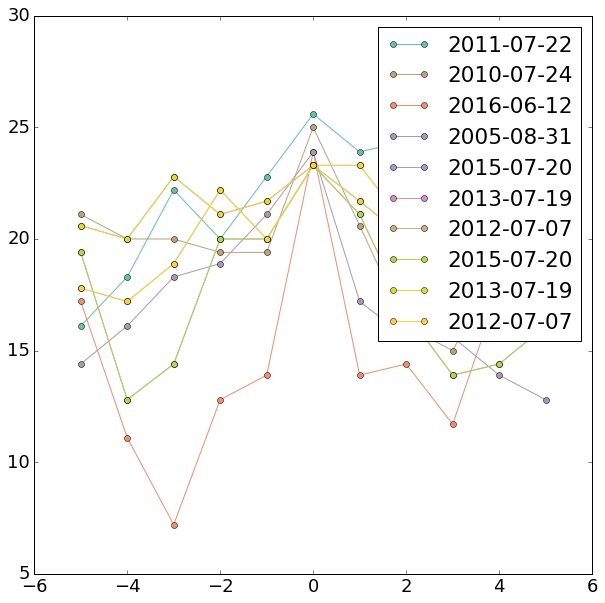

In [211]:
plt.figure(figsize=[10,10])
plt.plot(np.arange(-5,6),compositeTemp.T, '-o')
plt.legend(heatwaves.index.tolist())

In [233]:
hottestmin = rural_summer.iloc[(-rural_summer.values).argsort()[:numhw]] 
minheatwaves = hottestmin[0:12]

Ns = []
m = 0 
for n in range(1,11): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:20]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# plot composite heatwave events
heatwaves = finalhw
compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
ii = 0
for dates in heatwaves.index: 
    compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

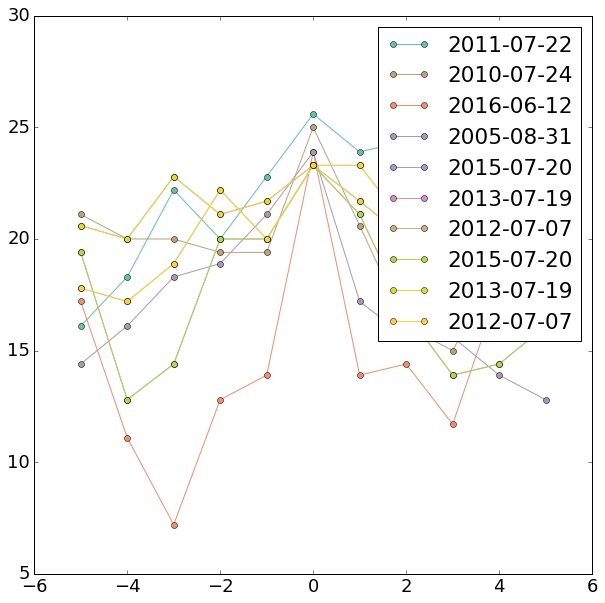

In [234]:
plt.figure(figsize=[10,10])
plt.plot(np.arange(-5,6),compositeTemp.T, '-o')
plt.legend(heatwaves.index.tolist())

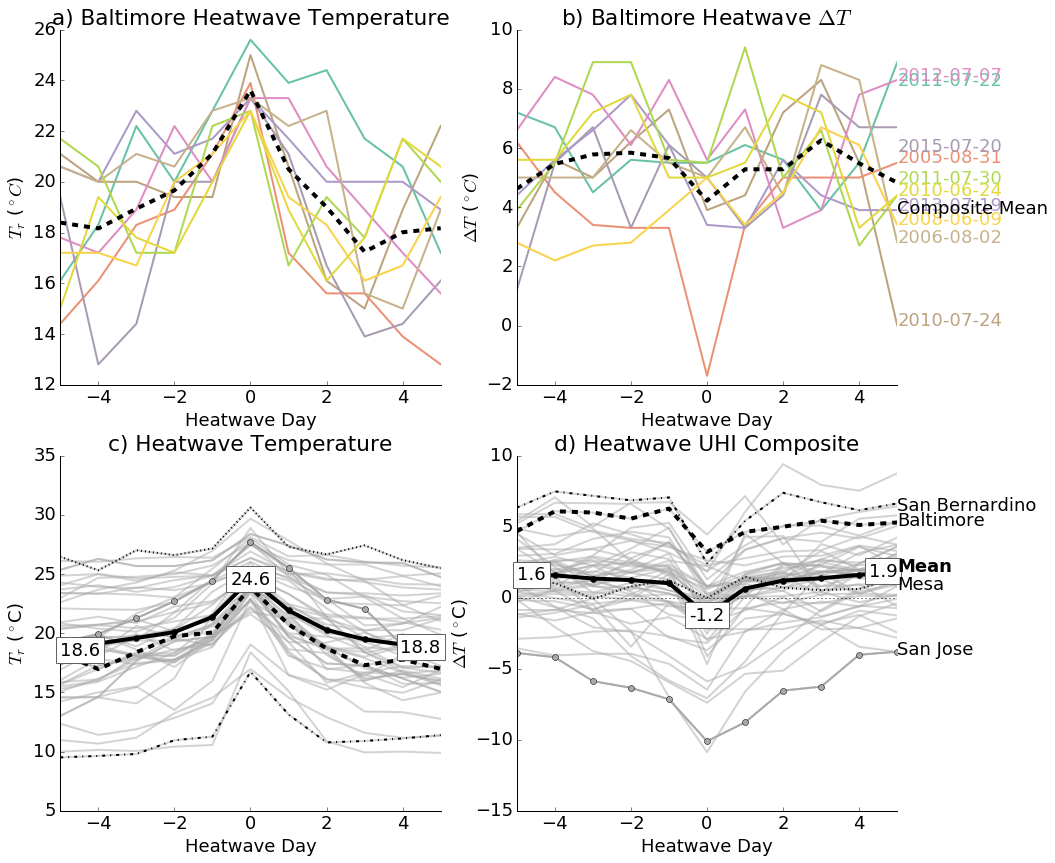

In [239]:
Ns = []
m = 0 
for n in range(1,11): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:20]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# plot composite heatwave events
heatwaves = finalhw
compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
ii = 0
for dates in heatwaves.index: 
    compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

plt.figure(figsize=[15,14])
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', plt.cm.Set2(np.linspace(0.0,0.75,10)))))
bmorec = 'k'
plt.subplot(2,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), '--', 
         color = bmorec, 
         linewidth = 4, )
plt.title('a) %s Heatwave Temperature'%(city))
plt.ylabel('$T_r$ ($^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
#plt.legend(legend_str,loc = 2)
prettify_plot()

plt.subplot(2,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, linewidth = 2)
plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0),
         '--',color = bmorec, linewidth = 4, label = 'Composite Mean Event'),#color = 'black',)

plt.title('b) %s Heatwave $\Delta T$'%(city))
plt.ylabel('$\Delta T $ ($ ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
prettify_plot()
i = 0
for date in heatwaves.index: 
    if ~np.isnan(compositeUHI[i][10]): 
        if i ==0 : 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color()) # 1994-08-03
        elif i ==3: 
            plt.text(5, compositeUHI[i][10]-.8, date, color = tHandle[i].get_color())#, color = plt.cm.viridis(i)) 1993-07-08
        elif i ==7: 
            plt.text(5, compositeUHI[i][10]+.4, date, color = tHandle[i].get_color())# 1993-07-08
        else: 
            plt.text(5, compositeUHI[i][10], date, color = tHandle[i].get_color())#, verticalalignment='center', horizontalalignment='left')#, color = plt.cm.viridis(i))
    else: 
        plt.text(1, compositeUHI[i][6]+1, date, verticalalignment='top', horizontalalignment='center', color = tHandle[i].get_color())#, color = 'red')#plt.cm.viridis(i))

    i = i+1
plt.text(5,np.nanmean(compositeUHI, axis=0)[9]-1.7, 'Composite Mean', color = 'black')

# plot heatwave composites for all stations
#plt.figure(figsize = [15,5])
#plot temperature,raw
plt.subplot(2,2,3)
for i in range(0, compositeTempDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeTempDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')

#plt.errorbar(x,compositeTempDF.mean(), yerr=compositeTempDF.std(), color = 'k', zorder = 1)
#compositeTempDF.mean(axis=0).plot(yerr = compositeTempDF.std(axis=0))
# plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
# plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
# plt.plot(x, compositeTempDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
# plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

plt.plot(x, compositeTempDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
#plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeTempDF.loc['Mesa'], ':', color = 'k', alpha = 1, linewidth = 2, label = 'Mesa')
plt.plot(x, compositeTempDF.loc['San Bernardino'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'San Bernadino')
plt.plot(x, compositeTempDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')


plt.plot( x, compositeTempDF.mean(), '-o', color = 'k', linewidth = 4)
plt.xlabel('Heatwave Day')
plt.ylabel('$T_r$ ($^\circ$C)')
plt.title('c) Heatwave Temperature')
plt.xlim([-5,5])
xx = -5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeTempDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4],'%s'%compositeTempDF.mean(axis=1).argmin())
# plt.text(2,compositeTempDF.loc[compositeTempDF.mean(axis=1).argmax()][4],'%s'%compositeTempDF.mean(axis=1).argmax())
# plt.text(2,compositeTempDF.loc['Baltimore'][4],'Baltimore', color = bmorec, zorder = 0)
prettify_plot()

#plot UHI, raw
plt.subplot(2,2,4)

for i in range(0, compositeUHIDF.shape[0]) : 
    #print compositeUHIDF2.iloc[i].values[1:]
    plt.plot(x, compositeUHIDF.iloc[i].values[0:], color = 'DarkGray', zorder = 0, alpha = .5, linewidth = 2)#, '-o')
plt.plot( x, compositeUHIDF.mean(), '-o', color = 'k', linewidth = 4,)
#plt.errorbar(x,compositeUHIDF.mean(), yerr=compositeUHIDF.std(), color = 'k', zorder = 1)
plt.axhline(0, linestyle = ':', color = 'k')

plt.xlabel('Heatwave Day')
plt.xlim([-5,5])
plt.ylabel('$\Delta T$ ($^\circ$C)')
plt.title('d) Heatwave UHI Composite')
prettify_plot()

xx = -5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='left')

xx = 0
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'), 
         verticalalignment='center', horizontalalignment='center'
                 )
xx = 5
yy = compositeUHIDF.mean()[xx]
plt.text(xx,yy,'%2.1f'%yy,
                 bbox=dict(facecolor='white', edgecolor = '#636363'),
                 verticalalignment='center', horizontalalignment='right')

plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmin()][4],'%s'%compositeUHIDF.mean(axis=1).argmin())
plt.text(5,compositeUHIDF.loc[compositeUHIDF.mean(axis=1).argmax()][4],'%s'%compositeUHIDF.mean(axis=1).argmax())
plt.text(5,compositeUHIDF.loc['Baltimore'][4],'Baltimore', color = bmorec)
plt.text(5,compositeUHIDF.loc['Mesa'][4],'Mesa', color = 'k')
plt.text(5, compositeUHIDF.mean()[5], 'Mean', color = 'k', weight = 'bold')

# plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
# plt.plot(x, compositeUHIDF.loc['Albuquerque'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'Albuquerque')
# plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')
# plt.plot(x, compositeUHIDF.loc['Phoenix'], ':', color = 'k', zorder = 0, alpha = 1, linewidth = 4, label = 'Phoenix')

plt.plot(x, compositeUHIDF.loc['Baltimore'], '--', color = bmorec, alpha = 1, linewidth = 4, label = 'Baltimore')
#plt.plot(x, compositeTempDF.loc['Phoenix'], ':', color = 'k', alpha = 1, linewidth = 4, label = 'Phoenix')
plt.plot(x, compositeUHIDF.loc['Mesa'], ':', color = 'k', alpha = 1, linewidth = 2, label = 'Mesa')
plt.plot(x, compositeUHIDF.loc['San Bernardino'], '-.', color = 'k', alpha = 1, linewidth = 2, label = 'San Bernadino')
plt.plot(x, compositeUHIDF.loc['San Jose'], '-o', color = 'DarkGray', zorder = 0, alpha = 1, linewidth = 2, label = 'San Jose')

#plt.legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))

plt.savefig(results_filepath+ 'hwcompositeTMIN.pdf',bbox_inches='tight')

In [240]:
np.nanmean(compositeUHI, axis=0)

array([ 4.62,  5.46,  5.78,  5.84,  5.66,  4.22,  5.28,  5.28,  6.26,
        5.48,  4.83])

In [226]:
np.nanmean(compositeUHI, axis=0)

array([ 4.62,  5.46,  5.78,  5.84,  5.66,  4.22,  5.28,  5.28,  6.26,
        5.48,  4.83])

'USW00093784'

In [241]:
compositeUHIDF.loc['Baltimore']

-5    4.677778
-4    6.088889
-3    6.000000
-2    5.566667
-1    6.277778
 0    3.222222
 1    4.633333
 2    5.000000
 3    5.422222
 4    5.122222
 5    5.300000
Name: Baltimore, dtype: float64

In [236]:
Ns = []
m = 0 
for n in range(1,11): 
    old = m
    try: 
        while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
            m = m+1
    except IndexError: 
        minheatwaves = hottestmin[0:20]
        try: 
            while minheatwaves.sort_index().index[m+1].to_timestamp() - minheatwaves.sort_index().index[m].to_timestamp()  < np.timedelta64(3, 'D') : 
                m = m+1
        except IndexError: 
            print('out of bounds')
    try: 
        if old ==m : 
            Ns.append(minheatwaves.sort_index().index[m])
        else: 
            Ns.append(minheatwaves.sort_index()[old:m].argmax())
    except: 
        'random error'
    m = m+1
finalhw = hottestmin[Ns].sort_values(ascending=False)

# plot composite heatwave events
heatwaves = finalhw
compositeTemp = np.nan*np.ones([heatwaves.shape[0], 11])
compositeUHI = np.nan*np.ones([heatwaves.shape[0], 11])
ii = 0
for dates in heatwaves.index: 
    compositeTemp[ii,:]= rural_tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
    compositeUHI[ii,:] = (urban_tmin-rural_tmin)[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values# -UHI[dates.to_timestamp()]
    ii = ii+1

In [ ]:
compositeUHI

In [237]:
finalhw

month_period
2011-07-22    25.6
2010-07-24    25.0
2005-08-31    23.9
2015-07-20    23.3
2013-07-19    23.3
2012-07-07    23.3
2006-08-02    23.3
2011-07-30    22.8
2010-06-24    22.8
2008-06-09    22.8
Freq: D, Name: value, dtype: float64

In [220]:
finalhw

month_period
2011-07-22    25.6
2010-07-24    25.0
2005-08-31    23.9
2015-07-20    23.3
2013-07-19    23.3
2012-07-07    23.3
2006-08-02    23.3
2011-07-30    22.8
2010-06-24    22.8
2008-06-09    22.8
Freq: D, Name: value, dtype: float64

In [197]:
finalhw

month_period
2011-07-22    25.6
2010-07-24    25.0
2005-08-31    23.9
2015-07-20    23.3
2013-07-19    23.3
2012-07-07    23.3
2006-08-02    23.3
2011-07-30    22.8
2010-06-24    22.8
2008-06-09    22.8
Freq: D, Name: value, dtype: float64

In [198]:
finalhw.shape

(10,)

In [174]:
compositeTemp[:,5]

array([ 25.6,  25. ,  23.9,  23.3,  23.3,  23.3,  23.3,  22.8,  22.8,  22.8])

array([[ 16.1,  18.3,  22.2,  20. ,  22.8,  25.6,  23.9,  24.4,  21.7,
         20.6,  17.2],
       [ 21.1,  20. ,  20. ,  19.4,  19.4,  25. ,  20.6,  16.1,  15. ,
         18.9,  22.2],
       [ 17.2,  11.1,   7.2,  12.8,  13.9,  23.9,  13.9,  14.4,  11.7,
         17.8,  15.6],
       [ 14.4,  16.1,  18.3,  18.9,  21.1,  23.9,  17.2,  15.6,  15.6,
         13.9,  12.8],
       [ 19.4,  12.8,  14.4,  20. ,  20. ,  23.3,  21.1,  16.7,  13.9,
         14.4,  16.1],
       [ 20.6,  20. ,  22.8,  21.1,  21.7,  23.3,  21.7,  20. ,  20. ,
         20. ,  18.9],
       [ 17.8,  17.2,  18.9,  22.2,  20. ,  23.3,  23.3,  20.6,  18.9,
         17.2,  15.6],
       [ 19.4,  12.8,  14.4,  20. ,  20. ,  23.3,  21.1,  16.7,  13.9,
         14.4,  16.1],
       [ 20.6,  20. ,  22.8,  21.1,  21.7,  23.3,  21.7,  20. ,  20. ,
         20. ,  18.9],
       [ 17.8,  17.2,  18.9,  22.2,  20. ,  23.3,  23.3,  20.6,  18.9,
         17.2,  15.6]])

In [175]:
compositeTemp

array([[ 16.1,  18.3,  22.2,  20. ,  22.8,  25.6,  23.9,  24.4,  21.7,
         20.6,  17.2],
       [ 21.1,  20. ,  20. ,  19.4,  19.4,  25. ,  20.6,  16.1,  15. ,
         18.9,  22.2],
       [ 14.4,  16.1,  18.3,  18.9,  21.1,  23.9,  17.2,  15.6,  15.6,
         13.9,  12.8],
       [ 19.4,  12.8,  14.4,  20. ,  20. ,  23.3,  21.1,  16.7,  13.9,
         14.4,  16.1],
       [ 20.6,  20. ,  22.8,  21.1,  21.7,  23.3,  21.7,  20. ,  20. ,
         20. ,  18.9],
       [ 17.8,  17.2,  18.9,  22.2,  20. ,  23.3,  23.3,  20.6,  18.9,
         17.2,  15.6],
       [ 20.6,  20. ,  21.1,  20.6,  22.8,  23.3,  22.2,  22.8,  15.6,
         15. ,  18.9],
       [ 21.7,  20.6,  17.2,  17.2,  22.2,  22.8,  16.7,  19.4,  17.8,
         21.7,  20. ],
       [ 15. ,  19.4,  17.8,  17.2,  20. ,  22.8,  18.9,  16.1,  17.8,
         21.7,  20.6],
       [ 17.2,  17.2,  16.7,  20. ,  21.1,  22.8,  19.4,  18.3,  16.1,
         16.7,  19.4]])

In [185]:
heatwaves.index.tolist()

[Period('2011-07-22', 'D'),
 Period('2010-07-24', 'D'),
 Period('2005-08-31', 'D'),
 Period('2015-07-20', 'D'),
 Period('2013-07-19', 'D'),
 Period('2012-07-07', 'D'),
 Period('2006-08-02', 'D'),
 Period('2011-07-30', 'D'),
 Period('2010-06-24', 'D'),
 Period('2008-06-09', 'D')]

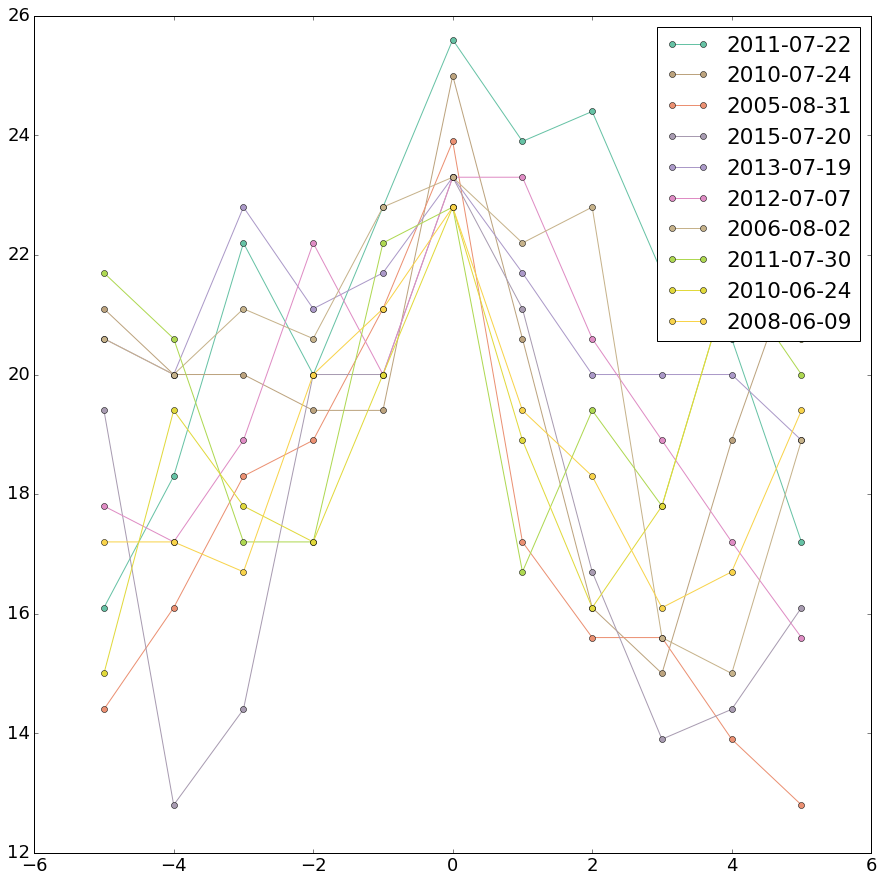

In [238]:
plt.figure(figsize=[15,15])
plt.plot(np.arange(-5,6),compositeTemp.T, '-o')
plt.legend(heatwaves.index.tolist())

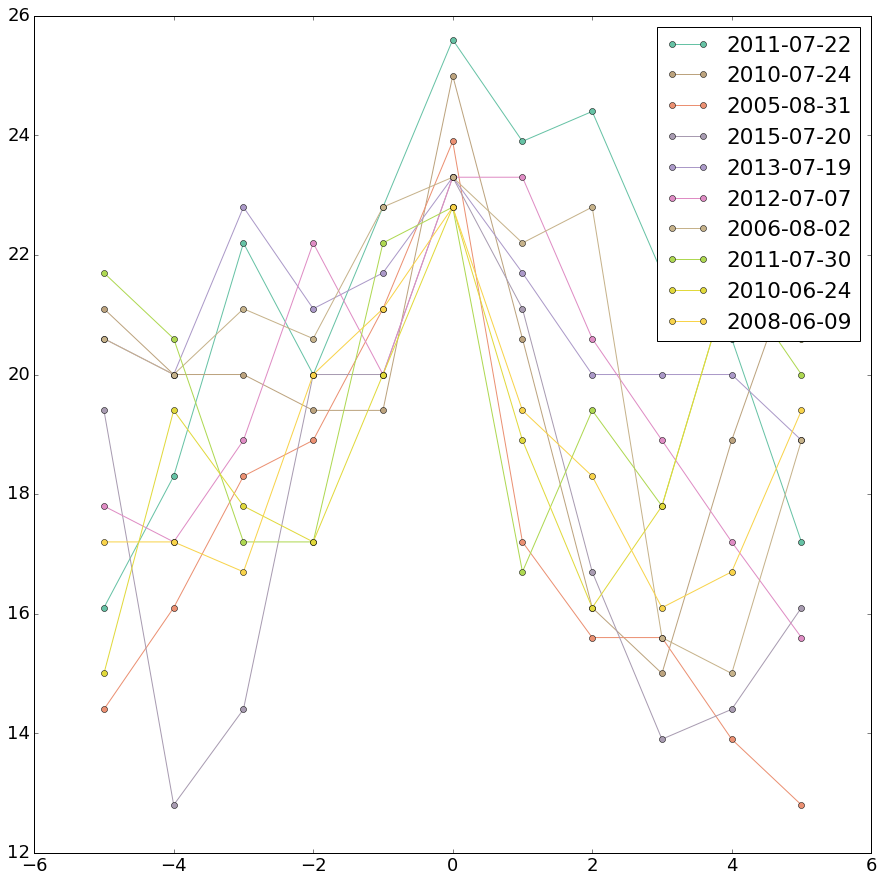

In [191]:
plt.figure(figsize=[15,15])
plt.plot(np.arange(-5,6),compositeTemp.T, '-o')
plt.legend(heatwaves.index.tolist())

In [161]:
paired_df.shape

(53, 14)

In [441]:
i

9

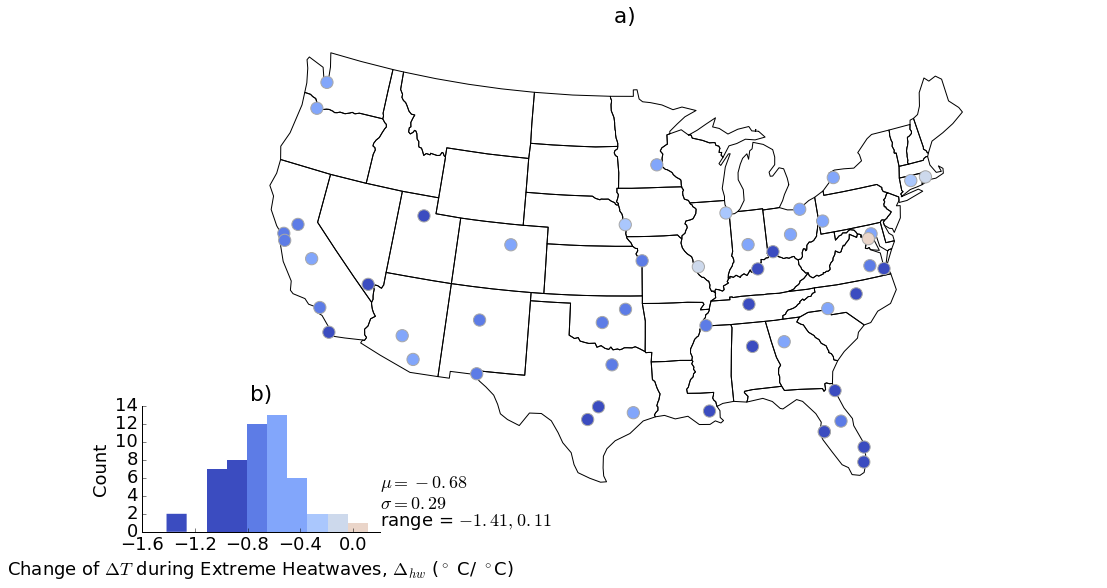

In [163]:
# extreme heatwave sensitivity map
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
data = compositeUHIDF[0].subtract(compositeUHIDF[-5])/compositeTempDF[0].subtract(compositeTempDF[-5])#.drop(drop_cities)
fig, ax, sub_ax = map_hist_plot(data, paired_df, title = 'Extreme Heatwaves', 
                    data_label='Change of $\Delta T$ during Extreme Heatwaves, $\Delta_{hw}$ ($^\circ$ C/ $^\circ $C)', 
                ) 
sub_ax.set_xticks(sub_ax.get_xticks()[::2])
plt.savefig(results_filepath+ 'extreme_hw_map.pdf', bbox_inches='tight')

In [168]:
data = compositeUHIDF[0].subtract(compositeUHIDF[-5])/compositeTempDF[0].subtract(compositeTempDF[-5])

In [55]:
compositeTempDF.loc[compositeTempDF.mean(axis=1).argmin()][4]

7.8333333333333348

In [56]:
compositeTempDF.mean(axis=1).argmin()

'Albuquerque'

In [57]:
compositeTempDF.mean(axis=1).argmax()

'Phoenix'

In [58]:
compositeUHIDF.mean() - compositeUHIDF.mean()[-5]

-5    0.000000
-4   -0.044349
-3   -0.248405
-2   -0.272337
-1   -0.489324
 0   -4.659501
 1   -1.304766
 2   -0.762409
 3   -0.712969
 4   -0.298066
 5   -0.130592
dtype: float64

In [59]:
compositeTempDF.mean() - compositeTempDF.mean()[-5]

-5    0.000000
-4    0.305249
-3    0.663975
-2    1.336077
-1    2.429975
 0    6.873858
 1    2.501363
 2    1.199462
 3    0.694046
 4    0.110860
 5    0.009745
dtype: float64

In [60]:
(compositeUHIDF.mean() - compositeUHIDF.mean()[-5])[0] / (compositeTempDF.mean() - compositeTempDF.mean()[-5])[0]

-0.67785823015066893

In [61]:
-4.65/6.87

-0.6768558951965066

In [62]:
(compositeUHIDF[0]< 0).sum()

44

In [63]:
(compositeUHIDF[0]> 0).sum()

9

In [64]:
compositeUHIDF.shape

(53, 11)

In [ ]:
# Plot boxplots of slopes
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
JJAresults = pd.read_csv('plots/version3/US_results_cleaned_data.csv').set_index('City').drop(drop_cities, axis=0)

#cities = paired_df['City'].values
cities = JJAresults.index.values
M_list = []
for city in cities: #i in range(0,cities.shape[0]): # probalby need to redo 1-15
    #city = paired_df.iloc[i]['City']
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
        #M_list.append(np.load(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
    except IOError: 
#        M_list.append(np.loadtxt(results_filepath+'slopes/'+ city.replace(" ", "")[0:5]+'m.npy'))
        print('Skipping %s'%city)

plt.figure(figsize=[20,10])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')
#Now load the calculated results 
#JJAresults = pd.read_csv('US_results_cleaned_data.csv').set_index('City')
#set up fake x axis
X = np.arange(1, cities.shape[0]+1)
Y = JJAresults['Slope'].loc[cities]
ax.axhline(Y.mean(), color = 'lightgray', label = '$\overline{m}$, this study')
ax.axhline(0, color = 'black', )
ax.plot(X,Y, '*', color = 'black', markerSize = 10, label = 'This study $m$')
ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)
ax.set_ylabel('$m_{day}$ ($^\circ$C/$^\circ$C)')
#ax.set_title('Slope of UHI response to Temperature')
plt.ylim([-1., .25])
plt.legend()
plt.savefig(results_filepath+'allcitiesm.pdf', bbox_inches='tight')

In [ ]:
# Plot boxplots of UHI trend range
#results_filepath = 'plots/version2/UHIvariance_brightness_thresh/'
cities = []
M_list = []
for city in combined_cities: 
    if city == 'Grand Prairie': 
        city = 'Arlington'
    try: 
        array = np.load(results_filepath+'30yrtrend/'+ city.replace(" ", "")[0:5]+'30yrUHIslopes.npy')
        #array = np.load(results_filepath+'UHIs/'+ city.replace(" ", "")[0:5]+'UHI.npy')
        array = array[~np.isnan(array)]
        M_list.append(array)
        if city =='Arlington': 
            cities.append('Grand Prairie')
        else: 
            cities.append(city)
    except IOError: 
        print('Skipping %s'%city)

plt.figure(figsize=[20,10])
ax = plt.subplot(111) 
ax.boxplot(M_list, vert = True)
ax.hold('True')

X= np.arange(1, len(cities)+1)
Y= mydf.set_index('City')['UHI linear trend'][cities]# mydf['Mean UHI'][cities]
ax.axhline(Y.mean(), color = 'lightgray', label = 'Mean this study')
ax.axhline(0, color = 'black', )
ax.plot( X, Y,'*',#'x', 
        color = 'black', markerSize = 10, label = 'This study')
#ax.axhline(Y.mean(), color = 'black')
ax.plot(X,  ccUHIdf.set_index('City').loc[combined_cities]['UHI trend'],'*',#'x', 
        color = 'green', markerSize = 10, label = 'CC data')
#ax.axhline(ccUHIdf.set_index('City').loc[combined_cities]['UHI trend'].mean(), color = 'green')

ax.set_xlabel('City')
ax.set_xticklabels(cities, rotation = 90)

#plt.legend()
ax.set_ylabel('Annual Trend in $\Delta T$ ($^\circ$C/yr)')
ax.set_title('Possible UHI long term trends')
plt.ylim([-0.9, 1.0])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc =1) #loc='upper left', 
                #bbox_to_anchor=(1.0,0.5))
plt.savefig(results_filepath+'allcitiesUHItrend.pdf', bbox_inches='tight')

In [270]:
np.random.random?

(-0.0042316828591843283, -0.061140634494670679, 0.17225254490476657)

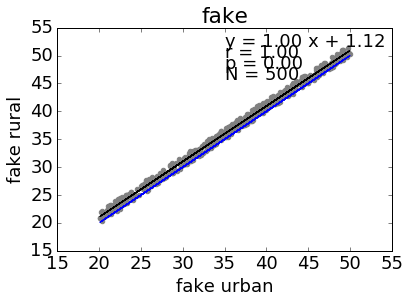

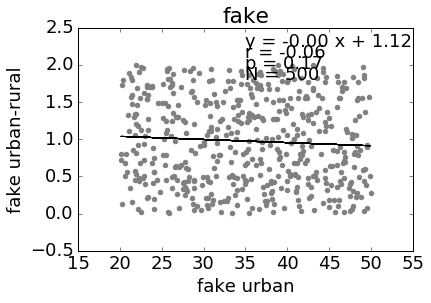

In [286]:
# mock up weather data
A = np.random.random(500)*30+20# dummy interval 20,50 
B = A + np.random.rand(500)*2
hw_scatter(A,B, 'fake','fake urban','fake rural')
plt.plot(A,A)
plt.figure()
hw_scatter(A,B-A, 'fake','fake urban','fake urban-rural')

In [301]:
R = np.zeros([100])
for i in range(0,55):
    A = np.random.random(500)*30+20# dummy interval 20,50 
    B = A + np.random.rand(500)*10
    R[i] = pearsonr_autocorrelated(A, B-A)[0]

In [307]:
R.max()

0.1257606757994808

(0.0012900545965588907, 0.0039907165924316897, 0.92907225785575231)

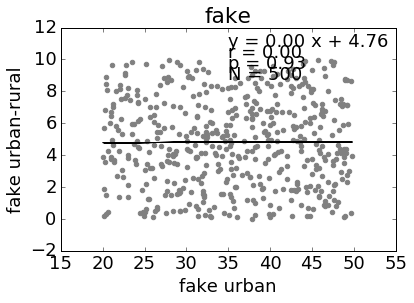

In [284]:
hw_scatter(A,B-A, 'fake','fake urban','fake urban-rural')

In [268]:
urban_summer[rural.shape, rural_summer.shape

((2944,), (2529,))

(0.7325647404610458, 0.72228588873171085, 0.0)

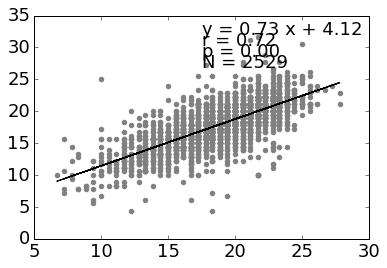

In [269]:
hw_scatter(urban_summer[rural_summer.index], rural_summer, '', '', '')

In [312]:
for i in range(0,15):
    A = np.random.random(500)*30+20# dummy interval 20,50 
    B = A + np.random.rand(500)*10
    print np.cov(A, B)[0,1]- np.var(A)

-0.794364808979
1.27407307141
1.27023330966
0.469485792603
1.15092908732
-0.0934555888362
-0.408964662477
0.811541105073
-1.49181492254
-2.01474224452
-0.0488208048767
-0.138572437994
-1.62269479058
0.952186640568
0.226804560496


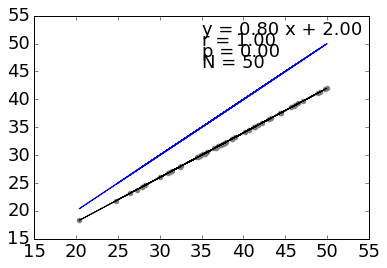

In [318]:
X = np.random.random(50)*30+20
b = 2
a = .8
hw_scatter(X, a*X+b, '', '', '')
plt.plot(X,X)